In [14]:
import os
import copy
import random
import time

import graphviz
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import wandb

import optuna
from optuna.samplers import TPESampler

from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, f1_score, classification_report, log_loss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

seed = 42
random.seed(seed)
np.random.seed(seed)
sampler = TPESampler(seed=seed)

In [5]:
save_vis = True
output_dir = 'ensembles_media'
if save_vis:
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

In [6]:
# Прочитаем датасет
dataset = pd.read_csv(
    '/home/rito4ka/dev/magistratura/miptml_projects/songs_classification/spotify-2023.csv',
    encoding='latin-1'
)

# Добавим категориальные коды для признаков
dataset['key'] = pd.Categorical(dataset['key'])
dataset['key'] = dataset['key'].cat.codes
dataset['mode'] = pd.Categorical(dataset['mode'])
dataset['mode'] = dataset['mode'].cat.codes

# Скастуем к инту то, что имело тип строки
dataset['in_deezer_playlists'] = [int(item.replace(',', '')) for item in dataset['in_deezer_playlists']]
dataset['in_shazam_charts'] = [int(item.replace(',', '')) if isinstance(item, str) else item
                               for item in dataset['in_shazam_charts']]

# Нагенерим столбец с целевым признаком
dataset['is_in_spotify_charts'] = [int(bool(item)) for item in dataset['in_spotify_charts']]

# Уберём лишние столбцы (Название трека и имя артиста; присутствие в плейлистах и чартах
# на платформах кроме Spotify, на Spotify скипнем только чарты, тк это целевой признак)
dataset = dataset.drop(
    ['artist(s)_name', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts',
     'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts'], axis=1
)

dataset.head()

,track_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,is_in_spotify_charts
0,Seven (feat. Latto) (Explicit Ver.),2,2023,7,14,553,141381703.0,125,2,0,80,89,83,31,0,8,4,1
1,LALA,1,2023,3,23,1474,133716286.0,92,3,0,71,61,74,7,0,10,4,1
2,vampire,1,2023,6,30,1397,140003974.0,138,7,0,51,32,53,17,0,31,6,1
3,Cruel Summer,1,2019,8,23,7858,800840817.0,170,0,0,55,58,72,11,0,11,15,1
4,WHERE SHE GOES,1,2023,5,18,3133,303236322.0,144,0,1,65,23,80,14,63,11,6,1


In [7]:
# Уберём имя песни и разделим на train и test выборки.
dataset = dataset.drop('track_name', axis=1)

# Обработаем nan
dataset = dataset.fillna(0)

X = dataset.drop('is_in_spotify_charts', axis=1)
y = dataset['is_in_spotify_charts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train_original = copy.deepcopy(X_train)
X_test_original = copy.deepcopy(X_test)

# Произведём масштабирование:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Обучение случайного леса**

Воспользуемся параметрами для лучшего одинокого дерева и поищем по сетке n_estimators - bootstrap

In [29]:
def find_best_forest(n_start:int, n_stop:int):
    result = []
    for n_est in tqdm(range(n_start, n_stop, 1)):
        for b in [True, False]:
            model = RandomForestClassifier(
            n_estimators = n_est,
            criterion = 'log_loss',
            max_depth = 9,
            min_samples_split = 4,
            min_samples_leaf = 5,
            min_weight_fraction_leaf = 0.05466435731880885,
            max_features = 'sqrt',
            max_leaf_nodes = 103,
            min_impurity_decrease = 0.00043010223839798253,
            bootstrap = b,
            random_state = seed,
            )

            model.fit(X_train_original, y_train)
            y_pred = model.predict(X_test_original)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
        
            result.append({
                'n': n_est,
                'b': b,
                'acc': accuracy,
                'f1': f1,
            })
        
            time.sleep(0.2) # Чтобы не "взлетать"
        
    max_by_acc = max(result, key=lambda x: x['acc'])
    max_by_f1 = max(result, key=lambda x: x['f1'])
    
    return {
        'results': result,
        'max_by_acc' : max_by_acc,
        'max_by_f1' : max_by_f1
    }

In [30]:
best_params = find_best_forest(2, 1000)

100%|████████████████████████████████████████████████████████████████████████████████████████| 998/998 [23:17<00:00,  1.40s/it]


In [31]:
print(best_params['max_by_acc'])
print(best_params['max_by_f1'])

{'n': 4, 'b': False, 'acc': 0.7225130890052356, 'f1': 0.7800829875518671}
{'n': 4, 'b': True, 'acc': 0.7120418848167539, 'f1': 0.782608695652174}


In [36]:
resulting_vals = best_params['results']
resulting_vals_bt = [
    [rv['n'] for rv in resulting_vals if rv['b']],
    [rv['acc'] for rv in resulting_vals if rv['b']],
    [rv['f1'] for rv in resulting_vals if rv['b']]
]

resulting_vals_bf = [
    [rv['n'] for rv in resulting_vals if not rv['b']],
    [rv['acc'] for rv in resulting_vals if not rv['b']],
    [rv['f1'] for rv in resulting_vals if not rv['b']]
]

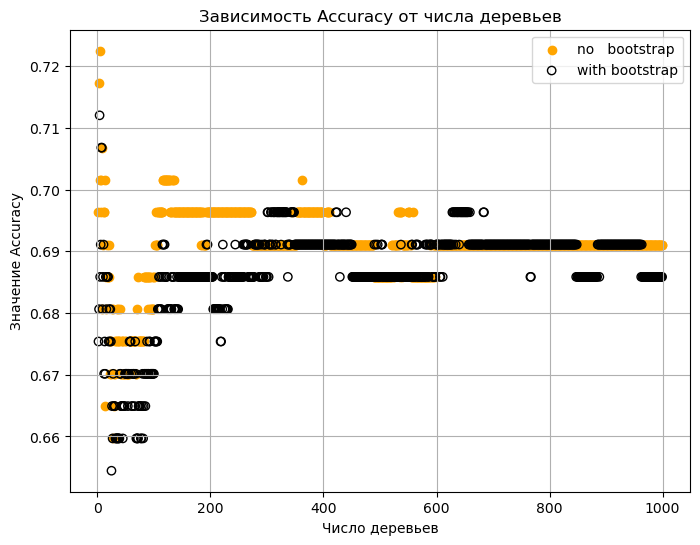

In [51]:
plt.figure(figsize=(8, 6))
plt.scatter(resulting_vals_bf[0], resulting_vals_bf[1], color='orange', label='no   bootstrap')
plt.scatter(resulting_vals_bt[0], resulting_vals_bt[1], facecolors='none', edgecolors='black', label='with bootstrap')
plt.grid()
plt.title('Зависимость Accuracy от числа деревьев')
plt.xlabel('Число деревьев')
plt.ylabel('Значение Accuracy')
plt.legend()

if save_vis:
    plt.savefig(output_dir + '/forest_acc.jpg')

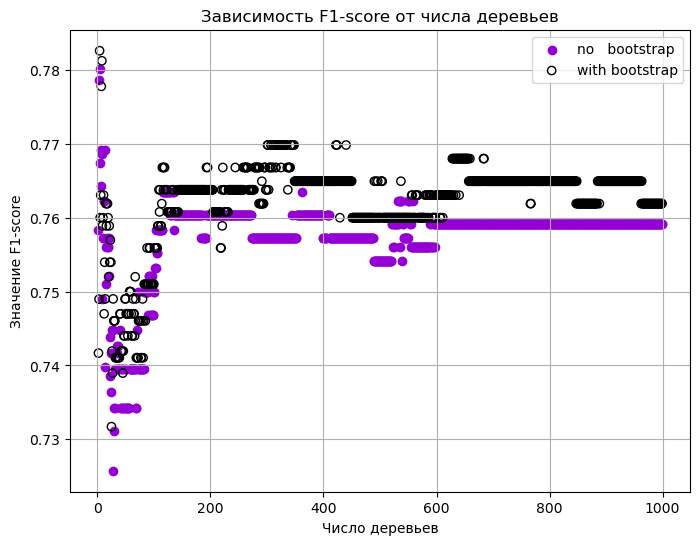

In [52]:
plt.figure(figsize=(8, 6))
plt.scatter(resulting_vals_bf[0], resulting_vals_bf[2], color='darkviolet', label='no   bootstrap')
plt.scatter(resulting_vals_bt[0], resulting_vals_bt[2], facecolors='none', edgecolors='black', label='with bootstrap')
plt.grid()
plt.title('Зависимость F1-score от числа деревьев')
plt.xlabel('Число деревьев')
plt.ylabel('Значение F1-score')
plt.legend()

if save_vis:
    plt.savefig(output_dir + '/forest_f1.jpg')

In [53]:
model = RandomForestClassifier(
    n_estimators = best_params['max_by_acc']['n'],
    criterion = 'log_loss',
    max_depth = 9,
    min_samples_split = 4,
    min_samples_leaf = 5,
    min_weight_fraction_leaf = 0.05466435731880885,
    max_features = 'sqrt',
    max_leaf_nodes = 103,
    min_impurity_decrease = 0.00043010223839798253,
    bootstrap = best_params['max_by_acc']['b'],
    random_state = seed,
)

model.fit(X_train_original, y_train)

y_pred = model.predict(X_test_original)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

f1 = f1_score(y_test, y_pred)
print(f'F1 score: {f1:.3f}')

report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

Accuracy: 0.723
F1 score: 0.780
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.61      0.62        72
           1       0.77      0.79      0.78       119

    accuracy                           0.72       191
   macro avg       0.70      0.70      0.70       191
weighted avg       0.72      0.72      0.72       191



In [54]:
model = RandomForestClassifier(
    n_estimators = best_params['max_by_f1']['n'],
    criterion = 'log_loss',
    max_depth = 9,
    min_samples_split = 4,
    min_samples_leaf = 5,
    min_weight_fraction_leaf = 0.05466435731880885,
    max_features = 'sqrt',
    max_leaf_nodes = 103,
    min_impurity_decrease = 0.00043010223839798253,
    bootstrap = best_params['max_by_f1']['b'],
    random_state = seed,
)

model.fit(X_train_original, y_train)

y_pred = model.predict(X_test_original)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

f1 = f1_score(y_test, y_pred)
print(f'F1 score: {f1:.3f}')

report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

Accuracy: 0.712
F1 score: 0.783
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.51      0.57        72
           1       0.74      0.83      0.78       119

    accuracy                           0.71       191
   macro avg       0.69      0.67      0.68       191
weighted avg       0.70      0.71      0.70       191



In [58]:
current_time = time.time()
for x in X_train:
    model.predict(x.reshape(1, -1))
passed_time = time.time() - current_time
print(f'inference time: {passed_time / len(X_train)}')

inference time: 0.00028863040793911994


**Градиентный бустинг**

In [61]:
def objective(trial):    
    learning_rate = trial.suggest_float(
        'learning_rate', 0., 1)
    n_estimators = trial.suggest_int(
        'n_estimators', 2, 1000)
    subsample = trial.suggest_float('subsample', 1e-6, 1.)
    criterion = trial.suggest_categorical(
        'criterion', ['friedman_mse', 'squared_error'])
    init = trial.suggest_categorical(
        'init', ['zero', None])
    
    model = GradientBoostingClassifier(
        loss='log_loss',
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        criterion=criterion,
        max_depth=9,
        min_samples_split=4,
        min_samples_leaf=5,
        min_weight_fraction_leaf=0.05466435731880885,
        min_impurity_decrease=0.00043010223839798253,
        init=init,
        max_features='sqrt',
        max_leaf_nodes=103,
        random_state=seed
    )
    
    model.fit(X_train_original, y_train)
    
    y_pred = model.predict(X_test_original)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [62]:
study = optuna.create_study(direction="maximize", sampler=sampler) 
study.optimize(objective, show_progress_bar=True)

[I 2023-11-07 14:34:11,987] A new study created in memory with name: no-name-2d79155f-a40b-452c-a062-4bd63d9fd08f
[I 2023-11-07 14:34:12,468] Trial 0 finished with value: 0.7486910994764397 and parameters: {'learning_rate': 0.3745401188473625, 'n_estimators': 951, 'subsample': 0.7319942098174633, 'criterion': 'friedman_mse', 'init': 'zero'}. Best is trial 0 with value: 0.7486910994764397.
[I 2023-11-07 14:34:12,705] Trial 1 finished with value: 0.675392670157068 and parameters: {'learning_rate': 0.8661761457749352, 'n_estimators': 602, 'subsample': 0.7080728697234677, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 0 with value: 0.7486910994764397.
[I 2023-11-07 14:34:12,851] Trial 2 finished with value: 0.7068062827225131 and parameters: {'learning_rate': 0.18182496720710062, 'n_estimators': 185, 'subsample': 0.30424293871729474, 'criterion': 'friedman_mse', 'init': None}. Best is trial 0 with value: 0.7486910994764397.
[I 2023-11-07 14:34:13,009] Trial 3 finished with va

[I 2023-11-07 14:34:24,670] Trial 29 finished with value: 0.743455497382199 and parameters: {'learning_rate': 0.19068600052497553, 'n_estimators': 833, 'subsample': 0.799924307970955, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 26 with value: 0.7591623036649214.
[I 2023-11-07 14:34:24,952] Trial 30 finished with value: 0.7225130890052356 and parameters: {'learning_rate': 0.3032404812266934, 'n_estimators': 590, 'subsample': 0.9257850904420644, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 26 with value: 0.7591623036649214.
[I 2023-11-07 14:34:25,323] Trial 31 finished with value: 0.7172774869109948 and parameters: {'learning_rate': 0.42496477327287446, 'n_estimators': 937, 'subsample': 0.8771876554702372, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 26 with value: 0.7591623036649214.
[I 2023-11-07 14:34:25,692] Trial 32 finished with value: 0.7591623036649214 and parameters: {'learning_rate': 0.16206852947364725, 'n_estimators': 870, 'sub

[I 2023-11-07 14:34:36,001] Trial 59 finished with value: 0.7120418848167539 and parameters: {'learning_rate': 0.14757212734877675, 'n_estimators': 935, 'subsample': 0.399410320885696, 'criterion': 'squared_error', 'init': None}. Best is trial 41 with value: 0.774869109947644.
[I 2023-11-07 14:34:36,247] Trial 60 finished with value: 0.7329842931937173 and parameters: {'learning_rate': 0.08848048850372484, 'n_estimators': 254, 'subsample': 0.8278552223062184, 'criterion': 'friedman_mse', 'init': 'zero'}. Best is trial 41 with value: 0.774869109947644.
[I 2023-11-07 14:34:36,584] Trial 61 finished with value: 0.7329842931937173 and parameters: {'learning_rate': 0.1245789128380402, 'n_estimators': 762, 'subsample': 0.9477061030506889, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 41 with value: 0.774869109947644.
[I 2023-11-07 14:34:36,936] Trial 62 finished with value: 0.7329842931937173 and parameters: {'learning_rate': 0.12121115519438143, 'n_estimators': 835, 'subsampl

[I 2023-11-07 14:34:47,817] Trial 89 finished with value: 0.7120418848167539 and parameters: {'learning_rate': 0.35818320947957616, 'n_estimators': 932, 'subsample': 0.6903873384189064, 'criterion': 'friedman_mse', 'init': 'zero'}. Best is trial 41 with value: 0.774869109947644.
[I 2023-11-07 14:34:48,170] Trial 90 finished with value: 0.7643979057591623 and parameters: {'learning_rate': 0.3077886412173642, 'n_estimators': 842, 'subsample': 0.5906236033080726, 'criterion': 'squared_error', 'init': None}. Best is trial 41 with value: 0.774869109947644.
[I 2023-11-07 14:34:48,514] Trial 91 finished with value: 0.7015706806282722 and parameters: {'learning_rate': 0.31931228511163945, 'n_estimators': 840, 'subsample': 0.604841539564795, 'criterion': 'squared_error', 'init': None}. Best is trial 41 with value: 0.774869109947644.
[I 2023-11-07 14:34:48,892] Trial 92 finished with value: 0.7329842931937173 and parameters: {'learning_rate': 0.30778065511329245, 'n_estimators': 944, 'subsample'

[I 2023-11-07 14:34:59,326] Trial 119 finished with value: 0.743455497382199 and parameters: {'learning_rate': 0.03868628807937156, 'n_estimators': 969, 'subsample': 0.9310169570330837, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 41 with value: 0.774869109947644.
[I 2023-11-07 14:34:59,696] Trial 120 finished with value: 0.7643979057591623 and parameters: {'learning_rate': 0.06626787474206432, 'n_estimators': 786, 'subsample': 0.6876274547001211, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 41 with value: 0.774869109947644.
[I 2023-11-07 14:35:00,055] Trial 121 finished with value: 0.7382198952879581 and parameters: {'learning_rate': 0.06955400923799424, 'n_estimators': 713, 'subsample': 0.6724404314957804, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 41 with value: 0.774869109947644.
[I 2023-11-07 14:35:00,497] Trial 122 finished with value: 0.7277486910994765 and parameters: {'learning_rate': 0.04731632773407441, 'n_estimators': 752, '

[I 2023-11-07 14:35:11,237] Trial 149 finished with value: 0.7172774869109948 and parameters: {'learning_rate': 0.025448003085729393, 'n_estimators': 930, 'subsample': 0.9634008677641355, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 41 with value: 0.774869109947644.
[I 2023-11-07 14:35:11,602] Trial 150 finished with value: 0.7382198952879581 and parameters: {'learning_rate': 0.39178680668233445, 'n_estimators': 886, 'subsample': 0.7148792041243196, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 41 with value: 0.774869109947644.
[I 2023-11-07 14:35:12,023] Trial 151 finished with value: 0.7277486910994765 and parameters: {'learning_rate': 0.08717080721911401, 'n_estimators': 907, 'subsample': 0.769050097547907, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 41 with value: 0.774869109947644.
[I 2023-11-07 14:35:12,109] Trial 152 finished with value: 0.6701570680628273 and parameters: {'learning_rate': 0.18381369003468437, 'n_estimators': 172, 

[I 2023-11-07 14:35:21,767] Trial 179 finished with value: 0.7225130890052356 and parameters: {'learning_rate': 0.313998192722973, 'n_estimators': 842, 'subsample': 0.5655356268647469, 'criterion': 'squared_error', 'init': None}. Best is trial 159 with value: 0.7801047120418848.
[I 2023-11-07 14:35:22,006] Trial 180 finished with value: 0.7225130890052356 and parameters: {'learning_rate': 0.15465754120035843, 'n_estimators': 497, 'subsample': 0.6201087305707859, 'criterion': 'squared_error', 'init': None}. Best is trial 159 with value: 0.7801047120418848.
[I 2023-11-07 14:35:22,355] Trial 181 finished with value: 0.7225130890052356 and parameters: {'learning_rate': 0.19598948065821656, 'n_estimators': 820, 'subsample': 0.582156901798155, 'criterion': 'squared_error', 'init': None}. Best is trial 159 with value: 0.7801047120418848.
[I 2023-11-07 14:35:22,707] Trial 182 finished with value: 0.7172774869109948 and parameters: {'learning_rate': 0.19534814780432563, 'n_estimators': 841, 'su

[I 2023-11-07 14:35:31,983] Trial 209 finished with value: 0.7120418848167539 and parameters: {'learning_rate': 0.3303499742421521, 'n_estimators': 773, 'subsample': 0.7106761426751407, 'criterion': 'squared_error', 'init': None}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:35:32,322] Trial 210 finished with value: 0.7277486910994765 and parameters: {'learning_rate': 0.29483776844518905, 'n_estimators': 759, 'subsample': 0.6810774465205669, 'criterion': 'squared_error', 'init': None}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:35:32,683] Trial 211 finished with value: 0.7382198952879581 and parameters: {'learning_rate': 0.21480920422622574, 'n_estimators': 793, 'subsample': 0.6535396062364113, 'criterion': 'squared_error', 'init': None}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:35:33,037] Trial 212 finished with value: 0.7172774869109948 and parameters: {'learning_rate': 0.18718484933813548, 'n_estimators': 785, '

[I 2023-11-07 14:35:42,801] Trial 239 finished with value: 0.7643979057591623 and parameters: {'learning_rate': 0.2749436471968306, 'n_estimators': 808, 'subsample': 0.9071190056467593, 'criterion': 'squared_error', 'init': None}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:35:43,142] Trial 240 finished with value: 0.7539267015706806 and parameters: {'learning_rate': 0.27743847111216524, 'n_estimators': 748, 'subsample': 0.9212299261882206, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:35:43,489] Trial 241 finished with value: 0.7120418848167539 and parameters: {'learning_rate': 0.30281046964426717, 'n_estimators': 796, 'subsample': 0.900682056714959, 'criterion': 'squared_error', 'init': None}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:35:43,850] Trial 242 finished with value: 0.7643979057591623 and parameters: {'learning_rate': 0.26466471546977977, 'n_estimators': 810, 

[I 2023-11-07 14:35:53,759] Trial 269 finished with value: 0.7696335078534031 and parameters: {'learning_rate': 0.05662667353687401, 'n_estimators': 759, 'subsample': 0.5751424001752135, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:35:54,131] Trial 270 finished with value: 0.7486910994764397 and parameters: {'learning_rate': 0.059455778483535934, 'n_estimators': 713, 'subsample': 0.5301003811759941, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:35:54,633] Trial 271 finished with value: 0.7382198952879581 and parameters: {'learning_rate': 0.017601652872504883, 'n_estimators': 763, 'subsample': 0.5599881472075243, 'criterion': 'squared_error', 'init': None}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:35:55,034] Trial 272 finished with value: 0.7277486910994765 and parameters: {'learning_rate': 0.042468520562023104, 'n_estimators'

[I 2023-11-07 14:36:06,470] Trial 299 finished with value: 0.7382198952879581 and parameters: {'learning_rate': 0.3837194771331234, 'n_estimators': 732, 'subsample': 0.859857965396297, 'criterion': 'squared_error', 'init': None}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:36:06,560] Trial 300 finished with value: 0.7539267015706806 and parameters: {'learning_rate': 0.09827994251828598, 'n_estimators': 79, 'subsample': 0.9330086754010033, 'criterion': 'squared_error', 'init': None}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:36:06,718] Trial 301 finished with value: 0.7172774869109948 and parameters: {'learning_rate': 0.6241924934303396, 'n_estimators': 285, 'subsample': 0.6755360310352448, 'criterion': 'squared_error', 'init': None}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:36:07,124] Trial 302 finished with value: 0.7172774869109948 and parameters: {'learning_rate': 0.18192063295157385, 'n_estimators': 905, 'sub

[I 2023-11-07 14:36:16,958] Trial 329 finished with value: 0.7172774869109948 and parameters: {'learning_rate': 0.18929784806230895, 'n_estimators': 934, 'subsample': 0.6314647751071495, 'criterion': 'squared_error', 'init': None}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:36:17,298] Trial 330 finished with value: 0.7486910994764397 and parameters: {'learning_rate': 0.259248185521897, 'n_estimators': 728, 'subsample': 0.9767864676101342, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:36:17,636] Trial 331 finished with value: 0.7277486910994765 and parameters: {'learning_rate': 0.14143341801284223, 'n_estimators': 603, 'subsample': 0.582197046754377, 'criterion': 'squared_error', 'init': None}. Best is trial 186 with value: 0.7853403141361257.
[I 2023-11-07 14:36:18,093] Trial 332 finished with value: 0.7486910994764397 and parameters: {'learning_rate': 0.04597447525020976, 'n_estimators': 835, '

[I 2023-11-07 14:36:28,815] Trial 359 finished with value: 0.7225130890052356 and parameters: {'learning_rate': 0.539428903881708, 'n_estimators': 954, 'subsample': 0.7495158753340548, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:36:29,225] Trial 360 finished with value: 0.743455497382199 and parameters: {'learning_rate': 0.14674152537572355, 'n_estimators': 799, 'subsample': 0.6952308530218887, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:36:29,588] Trial 361 finished with value: 0.7120418848167539 and parameters: {'learning_rate': 0.21540351778860123, 'n_estimators': 726, 'subsample': 0.6406934080432146, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:36:29,920] Trial 362 finished with value: 0.7225130890052356 and parameters: {'learning_rate': 0.2947870036918737, 'n_estimators': 831, 's

[I 2023-11-07 14:36:40,506] Trial 389 finished with value: 0.5445026178010471 and parameters: {'learning_rate': 0.6017901429020434, 'n_estimators': 922, 'subsample': 0.1897306667100196, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:36:40,823] Trial 390 finished with value: 0.5602094240837696 and parameters: {'learning_rate': 0.2693630981687044, 'n_estimators': 949, 'subsample': 0.030886516450105483, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:36:41,158] Trial 391 finished with value: 0.7277486910994765 and parameters: {'learning_rate': 0.21257078737451118, 'n_estimators': 799, 'subsample': 0.9025054361120749, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:36:41,459] Trial 392 finished with value: 0.6963350785340314 and parameters: {'learning_rate': 0.30419340421735097, 'n_estimators': 7

[I 2023-11-07 14:36:51,559] Trial 419 finished with value: 0.7172774869109948 and parameters: {'learning_rate': 0.3948545523706322, 'n_estimators': 837, 'subsample': 0.49735242834909077, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:36:51,922] Trial 420 finished with value: 0.7801047120418848 and parameters: {'learning_rate': 0.4139206113293723, 'n_estimators': 813, 'subsample': 0.725554530371213, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:36:52,277] Trial 421 finished with value: 0.7068062827225131 and parameters: {'learning_rate': 0.34776904603420267, 'n_estimators': 818, 'subsample': 0.7281637981993351, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:36:52,563] Trial 422 finished with value: 0.7329842931937173 and parameters: {'learning_rate': 0.4354685934643393, 'n_estimators': 571, '

[I 2023-11-07 14:37:01,575] Trial 449 finished with value: 0.7068062827225131 and parameters: {'learning_rate': 0.5377227817519102, 'n_estimators': 702, 'subsample': 0.6799886124087854, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:01,915] Trial 450 finished with value: 0.7329842931937173 and parameters: {'learning_rate': 0.5064246891226947, 'n_estimators': 829, 'subsample': 0.8044432959069641, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:02,291] Trial 451 finished with value: 0.7172774869109948 and parameters: {'learning_rate': 0.46503889749440575, 'n_estimators': 785, 'subsample': 0.7117871567686482, 'criterion': 'friedman_mse', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:02,632] Trial 452 finished with value: 0.7277486910994765 and parameters: {'learning_rate': 0.4096570333985554, 'n_estimators': 822, 'sub

[I 2023-11-07 14:37:11,680] Trial 479 finished with value: 0.7068062827225131 and parameters: {'learning_rate': 0.5607243997671556, 'n_estimators': 774, 'subsample': 0.39072793506191483, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:12,054] Trial 480 finished with value: 0.7643979057591623 and parameters: {'learning_rate': 0.38281004752521336, 'n_estimators': 899, 'subsample': 0.8097597276494222, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:12,324] Trial 481 finished with value: 0.7382198952879581 and parameters: {'learning_rate': 0.44534406077451777, 'n_estimators': 626, 'subsample': 0.7030177769669027, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:12,387] Trial 482 finished with value: 0.6230366492146597 and parameters: {'learning_rate': 0.15745009303499521, 'n_estimators': 136

[I 2023-11-07 14:37:22,472] Trial 509 finished with value: 0.7486910994764397 and parameters: {'learning_rate': 0.16232803379559047, 'n_estimators': 939, 'subsample': 0.7150776430874329, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:22,844] Trial 510 finished with value: 0.7329842931937173 and parameters: {'learning_rate': 0.5994344158780658, 'n_estimators': 841, 'subsample': 0.5497899106872748, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:23,158] Trial 511 finished with value: 0.7068062827225131 and parameters: {'learning_rate': 0.2682411820794793, 'n_estimators': 739, 'subsample': 0.26879068146348983, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:23,776] Trial 512 finished with value: 0.5549738219895288 and parameters: {'learning_rate': 0.6532382455238717, 'n_estimators': 999, 

[I 2023-11-07 14:37:34,110] Trial 538 finished with value: 0.7382198952879581 and parameters: {'learning_rate': 0.5608551758183697, 'n_estimators': 939, 'subsample': 0.45283475797712835, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:34,337] Trial 539 finished with value: 0.3769633507853403 and parameters: {'learning_rate': 0.21667444734336494, 'n_estimators': 788, 'subsample': 0.0009839586059285366, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:34,714] Trial 540 finished with value: 0.7172774869109948 and parameters: {'learning_rate': 0.4392567193484253, 'n_estimators': 900, 'subsample': 0.6947186586130438, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:35,033] Trial 541 finished with value: 0.7486910994764397 and parameters: {'learning_rate': 0.9997539925191236, 'n_estimators'

[I 2023-11-07 14:37:43,632] Trial 567 finished with value: 0.7225130890052356 and parameters: {'learning_rate': 0.4846523314985504, 'n_estimators': 489, 'subsample': 0.679185409660754, 'criterion': 'friedman_mse', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:44,026] Trial 568 finished with value: 0.7068062827225131 and parameters: {'learning_rate': 0.2962405508037745, 'n_estimators': 929, 'subsample': 0.7955092180423463, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:44,358] Trial 569 finished with value: 0.7382198952879581 and parameters: {'learning_rate': 0.6318882224582636, 'n_estimators': 813, 'subsample': 0.5613233256936113, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:44,782] Trial 570 finished with value: 0.7486910994764397 and parameters: {'learning_rate': 0.20523759251369034, 'n_estimators': 983, 'su

[I 2023-11-07 14:37:55,335] Trial 597 finished with value: 0.6701570680628273 and parameters: {'learning_rate': 0.8243304444746065, 'n_estimators': 810, 'subsample': 0.6855787894826282, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:55,682] Trial 598 finished with value: 0.7120418848167539 and parameters: {'learning_rate': 0.5980004738073676, 'n_estimators': 828, 'subsample': 0.6329298222450885, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:56,093] Trial 599 finished with value: 0.7277486910994765 and parameters: {'learning_rate': 0.54983009010314, 'n_estimators': 973, 'subsample': 0.7600669083984378, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:37:56,552] Trial 600 finished with value: 0.7120418848167539 and parameters: {'learning_rate': 0.495491721443376, 'n_estimators': 943, 'subs

[I 2023-11-07 14:38:07,811] Trial 627 finished with value: 0.7225130890052356 and parameters: {'learning_rate': 0.3335522989638781, 'n_estimators': 882, 'subsample': 0.8755840683425317, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:08,150] Trial 628 finished with value: 0.7486910994764397 and parameters: {'learning_rate': 0.31068195089707257, 'n_estimators': 753, 'subsample': 0.9324712944152238, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:08,668] Trial 629 finished with value: 0.518324607329843 and parameters: {'learning_rate': 0.6882067266728461, 'n_estimators': 924, 'subsample': 0.12398329065345448, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:09,039] Trial 630 finished with value: 0.7539267015706806 and parameters: {'learning_rate': 0.2511691695170439, 'n_estimators': 825,

[I 2023-11-07 14:38:19,094] Trial 657 finished with value: 0.5654450261780105 and parameters: {'learning_rate': 0.9852807653740904, 'n_estimators': 784, 'subsample': 0.13731619782083293, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:19,513] Trial 658 finished with value: 0.7905759162303665 and parameters: {'learning_rate': 0.11586754208138353, 'n_estimators': 951, 'subsample': 0.2283883176212269, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:19,948] Trial 659 finished with value: 0.7068062827225131 and parameters: {'learning_rate': 0.0974927888068796, 'n_estimators': 949, 'subsample': 0.37098411437981393, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:20,386] Trial 660 finished with value: 0.7382198952879581 and parameters: {'learning_rate': 0.12186483838295856, 'n_estimators': 981

[I 2023-11-07 14:38:31,669] Trial 686 finished with value: 0.6596858638743456 and parameters: {'learning_rate': 0.24552578049299464, 'n_estimators': 983, 'subsample': 0.23399963247541172, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:32,056] Trial 687 finished with value: 0.7015706806282722 and parameters: {'learning_rate': 0.5228133150986475, 'n_estimators': 962, 'subsample': 0.34940884359221525, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:32,642] Trial 688 finished with value: 0.5706806282722513 and parameters: {'learning_rate': 0.6250778917408075, 'n_estimators': 933, 'subsample': 0.18696657663979088, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:32,924] Trial 689 finished with value: 0.5549738219895288 and parameters: {'learning_rate': 0.665242142884487, 'n_estimators': 814,

[I 2023-11-07 14:38:43,242] Trial 715 finished with value: 0.7068062827225131 and parameters: {'learning_rate': 0.6087245711726063, 'n_estimators': 575, 'subsample': 0.729995215819163, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:43,526] Trial 716 finished with value: 0.5549738219895288 and parameters: {'learning_rate': 0.4796680448851446, 'n_estimators': 834, 'subsample': 0.025232164398734436, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:43,898] Trial 717 finished with value: 0.7382198952879581 and parameters: {'learning_rate': 0.3614540627440707, 'n_estimators': 861, 'subsample': 0.701145665888128, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:44,277] Trial 718 finished with value: 0.7225130890052356 and parameters: {'learning_rate': 0.31679527658194145, 'n_estimators': 885, '

[I 2023-11-07 14:38:55,143] Trial 744 finished with value: 0.7643979057591623 and parameters: {'learning_rate': 0.2951180320824115, 'n_estimators': 968, 'subsample': 0.896147641579966, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:55,620] Trial 745 finished with value: 0.7277486910994765 and parameters: {'learning_rate': 0.028420990474699124, 'n_estimators': 938, 'subsample': 0.9446666872982836, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:56,068] Trial 746 finished with value: 0.743455497382199 and parameters: {'learning_rate': 0.11294482340620099, 'n_estimators': 1000, 'subsample': 0.5003250131708717, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:38:56,389] Trial 747 finished with value: 0.7486910994764397 and parameters: {'learning_rate': 0.08538124674969974, 'n_estimators': 619,

[I 2023-11-07 14:39:06,539] Trial 774 finished with value: 0.7120418848167539 and parameters: {'learning_rate': 0.6206253213987973, 'n_estimators': 984, 'subsample': 0.37388668546433634, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:39:06,886] Trial 775 finished with value: 0.7696335078534031 and parameters: {'learning_rate': 0.3248329652054017, 'n_estimators': 796, 'subsample': 0.9269890566799077, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:39:07,319] Trial 776 finished with value: 0.7382198952879581 and parameters: {'learning_rate': 0.3242514769748846, 'n_estimators': 776, 'subsample': 0.9395820343905238, 'criterion': 'friedman_mse', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:39:07,672] Trial 777 finished with value: 0.743455497382199 and parameters: {'learning_rate': 0.32247070589571925, 'n_estimators': 795, 

[I 2023-11-07 14:39:17,472] Trial 803 finished with value: 0.7068062827225131 and parameters: {'learning_rate': 0.5167482891379621, 'n_estimators': 742, 'subsample': 0.3875546548715957, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:39:17,838] Trial 804 finished with value: 0.7068062827225131 and parameters: {'learning_rate': 0.9021578232732663, 'n_estimators': 816, 'subsample': 0.728163001331605, 'criterion': 'squared_error', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:39:18,495] Trial 805 finished with value: 0.581151832460733 and parameters: {'learning_rate': 0.8442907921182894, 'n_estimators': 970, 'subsample': 0.2619562272802376, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:39:18,774] Trial 806 finished with value: 0.7015706806282722 and parameters: {'learning_rate': 0.5474688617671739, 'n_estimators': 635, 'sub

[I 2023-11-07 14:39:29,970] Trial 833 finished with value: 0.743455497382199 and parameters: {'learning_rate': 0.20335231675597146, 'n_estimators': 609, 'subsample': 0.8361522016678591, 'criterion': 'friedman_mse', 'init': 'zero'}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:39:30,559] Trial 834 finished with value: 0.5863874345549738 and parameters: {'learning_rate': 0.9775782086597581, 'n_estimators': 859, 'subsample': 0.10771436818540403, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:39:30,967] Trial 835 finished with value: 0.7382198952879581 and parameters: {'learning_rate': 0.07350024507215579, 'n_estimators': 780, 'subsample': 0.6420562007011451, 'criterion': 'squared_error', 'init': None}. Best is trial 345 with value: 0.8010471204188482.
[I 2023-11-07 14:39:31,383] Trial 836 finished with value: 0.7329842931937173 and parameters: {'learning_rate': 0.3322838912270937, 'n_estimators': 943, '

KeyboardInterrupt: 

In [63]:
study.best_params

{'learning_rate': 0.5745251225407515,
 'n_estimators': 1000,
 'subsample': 0.9221357085288103,
 'criterion': 'squared_error',
 'init': None}

In [27]:
model = GradientBoostingClassifier(
    loss='log_loss',
    learning_rate=0.5745251225407515,
    n_estimators=1000,
    subsample=0.9221357085288103,
    criterion='squared_error',
    max_depth=9,
    min_samples_split=4,
    min_samples_leaf=5,
    min_weight_fraction_leaf=0.05466435731880885,
    min_impurity_decrease=0.00043010223839798253,
    init=None,
    max_features='sqrt',
    max_leaf_nodes=103,
    random_state=seed
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

f1 = f1_score(y_test, y_pred)
print(f'F1 score: {f1:.3f}')

report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

Accuracy: 0.801
F1 score: 0.835
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.79      0.75        72
           1       0.86      0.81      0.83       119

    accuracy                           0.80       191
   macro avg       0.79      0.80      0.79       191
weighted avg       0.81      0.80      0.80       191



In [75]:
current_time = time.time()
for x in X_train:
    model.predict(x.reshape(1, -1))
passed_time = time.time() - current_time
print(f'inference time: {passed_time / len(X_train)}')

inference time: 0.00032280060875759976


Попробуем CatBoost

In [18]:
model = CatBoostClassifier(random_seed=seed)    # Специалист Илья Петряшин сообщает,
                                # что дефолтные параметры дают лучшие результаты (чем вообще всё в мире)

model.fit(X_train_original, y_train, eval_set=(X_test_original, y_test))

Learning rate set to 0.029631
0:	learn: 0.6828736	test: 0.6851668	best: 0.6851668 (0)	total: 929us	remaining: 928ms
1:	learn: 0.6736430	test: 0.6777246	best: 0.6777246 (1)	total: 1.62ms	remaining: 807ms
2:	learn: 0.6646525	test: 0.6715696	best: 0.6715696 (2)	total: 2.25ms	remaining: 746ms
3:	learn: 0.6554071	test: 0.6654806	best: 0.6654806 (3)	total: 2.88ms	remaining: 718ms
4:	learn: 0.6467049	test: 0.6592546	best: 0.6592546 (4)	total: 3.57ms	remaining: 711ms
5:	learn: 0.6402207	test: 0.6545198	best: 0.6545198 (5)	total: 4.16ms	remaining: 689ms
6:	learn: 0.6336012	test: 0.6497990	best: 0.6497990 (6)	total: 4.75ms	remaining: 674ms
7:	learn: 0.6289856	test: 0.6464616	best: 0.6464616 (7)	total: 5.28ms	remaining: 655ms
8:	learn: 0.6231888	test: 0.6439988	best: 0.6439988 (8)	total: 5.83ms	remaining: 642ms
9:	learn: 0.6183243	test: 0.6408431	best: 0.6408431 (9)	total: 6.48ms	remaining: 642ms
10:	learn: 0.6145969	test: 0.6376752	best: 0.6376752 (10)	total: 7.08ms	remaining: 637ms
11:	learn: 0

315:	learn: 0.1993996	test: 0.5215950	best: 0.5141881 (288)	total: 192ms	remaining: 415ms
316:	learn: 0.1990436	test: 0.5219155	best: 0.5141881 (288)	total: 193ms	remaining: 415ms
317:	learn: 0.1979480	test: 0.5214959	best: 0.5141881 (288)	total: 193ms	remaining: 414ms
318:	learn: 0.1967145	test: 0.5212527	best: 0.5141881 (288)	total: 194ms	remaining: 414ms
319:	learn: 0.1958552	test: 0.5210810	best: 0.5141881 (288)	total: 194ms	remaining: 413ms
320:	learn: 0.1955183	test: 0.5211358	best: 0.5141881 (288)	total: 195ms	remaining: 413ms
321:	learn: 0.1947757	test: 0.5208573	best: 0.5141881 (288)	total: 196ms	remaining: 412ms
322:	learn: 0.1938223	test: 0.5201449	best: 0.5141881 (288)	total: 197ms	remaining: 412ms
323:	learn: 0.1930183	test: 0.5206810	best: 0.5141881 (288)	total: 197ms	remaining: 411ms
324:	learn: 0.1925754	test: 0.5210292	best: 0.5141881 (288)	total: 198ms	remaining: 411ms
325:	learn: 0.1917299	test: 0.5216726	best: 0.5141881 (288)	total: 199ms	remaining: 411ms
326:	learn

633:	learn: 0.0711314	test: 0.5662111	best: 0.5141881 (288)	total: 384ms	remaining: 222ms
634:	learn: 0.0709574	test: 0.5661356	best: 0.5141881 (288)	total: 385ms	remaining: 221ms
635:	learn: 0.0708963	test: 0.5662658	best: 0.5141881 (288)	total: 385ms	remaining: 221ms
636:	learn: 0.0707008	test: 0.5659573	best: 0.5141881 (288)	total: 386ms	remaining: 220ms
637:	learn: 0.0705150	test: 0.5659832	best: 0.5141881 (288)	total: 387ms	remaining: 219ms
638:	learn: 0.0703327	test: 0.5663415	best: 0.5141881 (288)	total: 388ms	remaining: 219ms
639:	learn: 0.0702383	test: 0.5666206	best: 0.5141881 (288)	total: 388ms	remaining: 218ms
640:	learn: 0.0700649	test: 0.5672122	best: 0.5141881 (288)	total: 389ms	remaining: 218ms
641:	learn: 0.0698150	test: 0.5668387	best: 0.5141881 (288)	total: 390ms	remaining: 218ms
642:	learn: 0.0696330	test: 0.5669490	best: 0.5141881 (288)	total: 391ms	remaining: 217ms
643:	learn: 0.0694796	test: 0.5669287	best: 0.5141881 (288)	total: 392ms	remaining: 217ms
644:	learn

931:	learn: 0.0380398	test: 0.6056071	best: 0.5141881 (288)	total: 577ms	remaining: 42.1ms
932:	learn: 0.0379705	test: 0.6056448	best: 0.5141881 (288)	total: 577ms	remaining: 41.5ms
933:	learn: 0.0378702	test: 0.6055826	best: 0.5141881 (288)	total: 578ms	remaining: 40.8ms
934:	learn: 0.0378367	test: 0.6054846	best: 0.5141881 (288)	total: 579ms	remaining: 40.2ms
935:	learn: 0.0377387	test: 0.6053176	best: 0.5141881 (288)	total: 579ms	remaining: 39.6ms
936:	learn: 0.0376878	test: 0.6053563	best: 0.5141881 (288)	total: 580ms	remaining: 39ms
937:	learn: 0.0375863	test: 0.6055040	best: 0.5141881 (288)	total: 581ms	remaining: 38.4ms
938:	learn: 0.0375210	test: 0.6056222	best: 0.5141881 (288)	total: 582ms	remaining: 37.8ms
939:	learn: 0.0374679	test: 0.6058952	best: 0.5141881 (288)	total: 583ms	remaining: 37.2ms
940:	learn: 0.0374013	test: 0.6065577	best: 0.5141881 (288)	total: 584ms	remaining: 36.6ms
941:	learn: 0.0372988	test: 0.6071819	best: 0.5141881 (288)	total: 585ms	remaining: 36ms
942

In [19]:
y_pred = model.predict(X_test_original)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

f1 = f1_score(y_test, y_pred)
print(f'F1 score: {f1:.3f}')

report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

Accuracy: 0.733
F1 score: 0.785
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.65      0.65        72
           1       0.79      0.78      0.78       119

    accuracy                           0.73       191
   macro avg       0.72      0.72      0.72       191
weighted avg       0.73      0.73      0.73       191



In [84]:
# эксперт ошибся... проверим на наших лучших параметрах.

model = CatBoostClassifier(
    loss_function='Logloss',
    learning_rate=0.5745251225407515,
    subsample=0.9221357085288103,
    depth=5,
    min_data_in_leaf=5,
    verbose=0,
    random_seed=seed,
)

model.fit(X_train_original, y_train, eval_set=(X_test_original, y_test))

y_pred = model.predict(X_test_original)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

f1 = f1_score(y_test, y_pred)
print(f'F1 score: {f1:.3f}')

report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

Accuracy: 0.759
F1 score: 0.807
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68        72
           1       0.81      0.81      0.81       119

    accuracy                           0.76       191
   macro avg       0.74      0.74      0.74       191
weighted avg       0.76      0.76      0.76       191



In [70]:
def objective(trial):
    params = {
        'loss_function': trial.suggest_categorical(
            'loss_function', ['Logloss', 'CrossEntropy', 'MultiClass', 'MultiClassOneVsAll']
        ),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.9),
        'subsample': trial.suggest_float('subsample', 0.01, 0.99),
        'depth': trial.suggest_int('depth', 1, 16),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'eval_metric': trial.suggest_categorical(
            'eval_metric', ['Accuracy']
        ),
        'bootstrap_type': 'Bernoulli',
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'random_seed': seed,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_original, y_train, eval_set=(X_test_original, y_test), early_stopping_rounds=50, verbose=0)

    y_pred = model.predict(X_test_original)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2000)

[I 2023-11-14 19:28:54,411] A new study created in memory with name: no-name-d9bd507b-286d-4e8c-849f-aa86a88fd41e
[I 2023-11-14 19:28:54,440] Trial 0 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'Logloss', 'iterations': 122, 'learning_rate': 0.8425103012946183, 'subsample': 0.6209366959658364, 'depth': 2, 'l2_leaf_reg': 66.33546725375336, 'border_count': 32, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.7486910994764397.
[I 2023-11-14 19:28:54,585] Trial 1 finished with value: 0.680628272251309 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 241, 'learning_rate': 0.006389659495170318, 'subsample': 0.17298109097423314, 'depth': 10, 'l2_leaf_reg': 64.90793165861547, 'border_count': 37, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.7486910994764397.
[I 2023-11-14 19:28:56,416] Trial 2 finished with value: 0.6910994764397905 and parameters: {'loss_function': 'MultiClassO

[I 2023-11-14 19:29:51,954] Trial 22 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'MultiClass', 'iterations': 583, 'learning_rate': 0.6860381072874224, 'subsample': 0.860166439088369, 'depth': 3, 'l2_leaf_reg': 33.85966124078882, 'border_count': 91, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 17 with value: 0.7696335078534031.
[I 2023-11-14 19:29:52,017] Trial 23 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'Logloss', 'iterations': 444, 'learning_rate': 0.5839580131013076, 'subsample': 0.7363951248204101, 'depth': 7, 'l2_leaf_reg': 16.688380321202544, 'border_count': 29, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.7696335078534031.
[I 2023-11-14 19:29:52,075] Trial 24 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'Logloss', 'iterations': 739, 'learning_rate': 0.7035725142220625, 'subsample': 0.851204621507988, 'depth': 4, 'l2_leaf_reg': 28.701

[I 2023-11-14 19:29:55,601] Trial 44 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 494, 'learning_rate': 0.6708306901742447, 'subsample': 0.8688840336518505, 'depth': 7, 'l2_leaf_reg': 22.258916126665607, 'border_count': 62, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:29:55,671] Trial 45 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 414, 'learning_rate': 0.5236759994662689, 'subsample': 0.9326681932459735, 'depth': 6, 'l2_leaf_reg': 38.75418221429798, 'border_count': 188, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:29:55,751] Trial 46 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'MultiClass', 'iterations': 798, 'learning_rate': 0.8288393041724071, 'subsample': 0.7857785652490098, 'depth': 5, 'l

[I 2023-11-14 19:29:57,270] Trial 66 finished with value: 0.7643979057591623 and parameters: {'loss_function': 'MultiClass', 'iterations': 733, 'learning_rate': 0.5590435980393078, 'subsample': 0.8947665338408862, 'depth': 4, 'l2_leaf_reg': 40.946947330007745, 'border_count': 15, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:29:57,369] Trial 67 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 503, 'learning_rate': 0.58792453759113, 'subsample': 0.9897925592997484, 'depth': 6, 'l2_leaf_reg': 19.696616759722364, 'border_count': 142, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:29:57,566] Trial 68 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 560, 'learning_rate': 0.5106631369088723, 'subsample': 0.9346098211862888, 'depth': 8, 'l2

[I 2023-11-14 19:30:08,587] Trial 88 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 306, 'learning_rate': 0.5320330367832145, 'subsample': 0.7943526744827903, 'depth': 4, 'l2_leaf_reg': 33.989480735149854, 'border_count': 213, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:30:08,661] Trial 89 finished with value: 0.774869109947644 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 710, 'learning_rate': 0.5752773055418798, 'subsample': 0.8735052165826407, 'depth': 4, 'l2_leaf_reg': 28.617960255832344, 'border_count': 86, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:30:08,749] Trial 90 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 751, 'learning_rate': 0.7812457256160161, 'subsample': 0.8627772590818112, 'depth': 7, 

[I 2023-11-14 19:30:10,187] Trial 110 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 633, 'learning_rate': 0.6149512014936157, 'subsample': 0.8727480841980054, 'depth': 6, 'l2_leaf_reg': 23.106657110020915, 'border_count': 170, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 5}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:30:10,275] Trial 111 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'MultiClass', 'iterations': 517, 'learning_rate': 0.5254739979973136, 'subsample': 0.9879128354552116, 'depth': 4, 'l2_leaf_reg': 34.62254381076116, 'border_count': 247, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 8}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:30:10,338] Trial 112 finished with value: 0.7643979057591623 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 155, 'learning_rate': 0.5266448172252735, 'subsample': 0.8423197440971109, 'depth': 3

[I 2023-11-14 19:30:11,975] Trial 132 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 672, 'learning_rate': 0.6387353133337161, 'subsample': 0.943573030026433, 'depth': 5, 'l2_leaf_reg': 44.66221387476493, 'border_count': 72, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 5}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:30:12,057] Trial 133 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 645, 'learning_rate': 0.6864912504130622, 'subsample': 0.9176918802131038, 'depth': 5, 'l2_leaf_reg': 29.65574401614502, 'border_count': 67, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:30:12,124] Trial 134 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 701, 'learning_rate': 0.6611073768966045, 'subsample': 0.9651534055379066, 'depth': 4, 'l2_le

[I 2023-11-14 19:30:14,927] Trial 154 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 733, 'learning_rate': 0.5588467800270878, 'subsample': 0.9661337009280099, 'depth': 4, 'l2_leaf_reg': 17.493332833173387, 'border_count': 179, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:30:15,002] Trial 155 finished with value: 0.7120418848167539 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 706, 'learning_rate': 0.5835569083727254, 'subsample': 0.5439968939779829, 'depth': 5, 'l2_leaf_reg': 20.0808914557286, 'border_count': 194, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:30:15,071] Trial 156 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 964, 'learning_rate': 0.6013531042972333, 'subsample': 0.9171167780136801, 'depth': 

[I 2023-11-14 19:30:41,104] Trial 176 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 575, 'learning_rate': 0.5443129192762595, 'subsample': 0.913781202363748, 'depth': 6, 'l2_leaf_reg': 21.720508896247644, 'border_count': 184, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:30:41,172] Trial 177 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'Logloss', 'iterations': 654, 'learning_rate': 0.7544313230913503, 'subsample': 0.9554044790608233, 'depth': 4, 'l2_leaf_reg': 24.704843268263957, 'border_count': 169, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 29 with value: 0.7801047120418848.
[I 2023-11-14 19:30:41,240] Trial 178 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 701, 'learning_rate': 0.7402643790712135, 'subsample': 0.989257057245729, 'depth': 5, 'l

[I 2023-11-14 19:30:42,950] Trial 198 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 712, 'learning_rate': 0.6529065877240301, 'subsample': 0.89607121903068, 'depth': 6, 'l2_leaf_reg': 26.245087155774836, 'border_count': 66, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 192 with value: 0.7958115183246073.
[I 2023-11-14 19:30:43,046] Trial 199 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 651, 'learning_rate': 0.5695475935839356, 'subsample': 0.9159298059817629, 'depth': 4, 'l2_leaf_reg': 60.198254624733146, 'border_count': 188, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 192 with value: 0.7958115183246073.
[I 2023-11-14 19:30:43,155] Trial 200 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 665, 'learning_rate': 0.5404984012231524, 'subsample': 0.7902608384613365, 'depth': 7

[I 2023-11-14 19:30:44,723] Trial 220 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'Logloss', 'iterations': 715, 'learning_rate': 0.6229494939205921, 'subsample': 0.9030388386894104, 'depth': 2, 'l2_leaf_reg': 18.64092662592832, 'border_count': 193, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 192 with value: 0.7958115183246073.
[I 2023-11-14 19:30:44,801] Trial 221 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'Logloss', 'iterations': 700, 'learning_rate': 0.6918980591165916, 'subsample': 0.956213980170412, 'depth': 4, 'l2_leaf_reg': 25.1520725947774, 'border_count': 183, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 192 with value: 0.7958115183246073.
[I 2023-11-14 19:30:44,902] Trial 222 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 683, 'learning_rate': 0.5856991135911952, 'subsample': 0.9293959502365715, 'depth': 5, 'l2_lea

[I 2023-11-14 19:30:46,743] Trial 242 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 555, 'learning_rate': 0.6548319688735705, 'subsample': 0.923589853973596, 'depth': 4, 'l2_leaf_reg': 33.36945130443544, 'border_count': 142, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:30:46,829] Trial 243 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 613, 'learning_rate': 0.5188504370912423, 'subsample': 0.16672988373581854, 'depth': 5, 'l2_leaf_reg': 44.77695676702091, 'border_count': 174, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:30:46,921] Trial 244 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 635, 'learning_rate': 0.7102175099879554, 'subsample': 0.94247609488632, 'depth': 6, 'l2_

[I 2023-11-14 19:30:48,519] Trial 264 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'Logloss', 'iterations': 396, 'learning_rate': 0.8410667877712283, 'subsample': 0.612188339732568, 'depth': 4, 'l2_leaf_reg': 17.99156743445148, 'border_count': 249, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:30:48,611] Trial 265 finished with value: 0.7643979057591623 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 871, 'learning_rate': 0.8879712523163124, 'subsample': 0.8420646513342984, 'depth': 4, 'l2_leaf_reg': 60.628113008845645, 'border_count': 179, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 8}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:30:48,683] Trial 266 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'Logloss', 'iterations': 706, 'learning_rate': 0.8236400520663724, 'subsample': 0.6436504215008683, 'depth': 5, 'l2_l

[I 2023-11-14 19:30:50,596] Trial 286 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 799, 'learning_rate': 0.7267278785172409, 'subsample': 0.9356813016644113, 'depth': 5, 'l2_leaf_reg': 43.1160601201258, 'border_count': 76, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:30:50,679] Trial 287 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 904, 'learning_rate': 0.7808059894402289, 'subsample': 0.7004525168774315, 'depth': 5, 'l2_leaf_reg': 32.20930813386675, 'border_count': 90, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:30:50,753] Trial 288 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 754, 'learning_rate': 0.8980300718668952, 'subsample': 0.8645500105306382, 'depth': 5, 'l2_l

[I 2023-11-14 19:31:02,348] Trial 308 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'Logloss', 'iterations': 824, 'learning_rate': 0.5811805456462228, 'subsample': 0.9264754286227286, 'depth': 5, 'l2_leaf_reg': 20.40414097809276, 'border_count': 65, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:02,425] Trial 309 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 656, 'learning_rate': 0.6861970087123338, 'subsample': 0.6267211570616629, 'depth': 4, 'l2_leaf_reg': 29.64734336210619, 'border_count': 137, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:02,501] Trial 310 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 722, 'learning_rate': 0.5564597649614409, 'subsample': 0.9587748957524592, 'depth': 5, 'l2_leaf

[I 2023-11-14 19:31:04,292] Trial 330 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 645, 'learning_rate': 0.674990399620278, 'subsample': 0.9615414298668437, 'depth': 5, 'l2_leaf_reg': 55.104494980977016, 'border_count': 255, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:04,369] Trial 331 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 691, 'learning_rate': 0.8997763381748228, 'subsample': 0.58594302159226, 'depth': 5, 'l2_leaf_reg': 50.055598871345026, 'border_count': 174, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:04,445] Trial 332 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 717, 'learning_rate': 0.8783059229634517, 'subsample': 0.6475854477468348, 'depth': 5, 'l

[I 2023-11-14 19:31:07,435] Trial 352 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 857, 'learning_rate': 0.6584119032581313, 'subsample': 0.8921999364095774, 'depth': 4, 'l2_leaf_reg': 11.50088490575872, 'border_count': 84, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:07,526] Trial 353 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 668, 'learning_rate': 0.49739417390654356, 'subsample': 0.9724210075692619, 'depth': 6, 'l2_leaf_reg': 39.701618237457595, 'border_count': 165, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:07,614] Trial 354 finished with value: 0.7225130890052356 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 704, 'learning_rate': 0.5185198353974677, 'subsample': 0.570513993313216, 'depth': 5, '

[I 2023-11-14 19:31:14,030] Trial 374 finished with value: 0.774869109947644 and parameters: {'loss_function': 'Logloss', 'iterations': 637, 'learning_rate': 0.8279324881119314, 'subsample': 0.8563463899155641, 'depth': 4, 'l2_leaf_reg': 60.93438816183311, 'border_count': 197, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:14,110] Trial 375 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 716, 'learning_rate': 0.6506818888420439, 'subsample': 0.5180671948264102, 'depth': 5, 'l2_leaf_reg': 16.84062597576449, 'border_count': 97, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:14,197] Trial 376 finished with value: 0.7643979057591623 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 547, 'learning_rate': 0.5888466473460575, 'subsample': 0.8838297321263949, 'depth': 4, 'l2_leaf_

[I 2023-11-14 19:31:18,314] Trial 396 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 738, 'learning_rate': 0.7231657297413135, 'subsample': 0.5937323450663938, 'depth': 4, 'l2_leaf_reg': 28.446437819821693, 'border_count': 76, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:18,400] Trial 397 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 751, 'learning_rate': 0.8004880807589138, 'subsample': 0.9718081889834048, 'depth': 5, 'l2_leaf_reg': 33.92900433931111, 'border_count': 83, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:18,503] Trial 398 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 715, 'learning_rate': 0.7064779153203341, 'subsample': 0.89952555572670

[I 2023-11-14 19:31:20,528] Trial 418 finished with value: 0.7801047120418848 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 710, 'learning_rate': 0.8378857672579659, 'subsample': 0.8586072836582712, 'depth': 4, 'l2_leaf_reg': 27.9248323622099, 'border_count': 77, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:20,601] Trial 419 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 712, 'learning_rate': 0.5302730487917997, 'subsample': 0.8621521634013456, 'depth': 3, 'l2_leaf_reg': 26.880659831077413, 'border_count': 78, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:20,687] Trial 420 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 731, 'learning_rate': 0.8491144107880584, 'subsample': 0.8427430676822644, 'depth': 

[I 2023-11-14 19:31:22,622] Trial 440 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 707, 'learning_rate': 0.6193262353593694, 'subsample': 0.6472609721519886, 'depth': 5, 'l2_leaf_reg': 34.44703960392628, 'border_count': 236, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:22,707] Trial 441 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 749, 'learning_rate': 0.5995483120962131, 'subsample': 0.5789155720527855, 'depth': 4, 'l2_leaf_reg': 15.380258694362118, 'border_count': 69, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:22,818] Trial 442 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 725, 'learning_rate': 0.8574897639502864, 'subsample': 0.5978849446474235, 'depth'

[I 2023-11-14 19:31:24,829] Trial 462 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 734, 'learning_rate': 0.48911718647156716, 'subsample': 0.930411936142309, 'depth': 6, 'l2_leaf_reg': 49.901643493892465, 'border_count': 141, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:24,929] Trial 463 finished with value: 0.7853403141361257 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 594, 'learning_rate': 0.8859621201747495, 'subsample': 0.5036203837096459, 'depth': 2, 'l2_leaf_reg': 54.86321544878423, 'border_count': 60, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:25,017] Trial 464 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 606, 'learning_rate': 0.8974245892018806, 'subsample': 0.527472675034504, 'depth': 2, 'l2

[I 2023-11-14 19:31:27,018] Trial 484 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 931, 'learning_rate': 0.5505841474311126, 'subsample': 0.8594228692523618, 'depth': 3, 'l2_leaf_reg': 29.395776280948727, 'border_count': 158, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:27,125] Trial 485 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 158, 'learning_rate': 0.8335885698226438, 'subsample': 0.583958578315641, 'depth': 6, 'l2_leaf_reg': 24.90438370371925, 'border_count': 146, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:27,215] Trial 486 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 618, 'learning_rate': 0.6289444286840089, 'subsample': 0.7451942200726024, 'depth':

[I 2023-11-14 19:31:50,302] Trial 506 finished with value: 0.7120418848167539 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 733, 'learning_rate': 0.5996310270136315, 'subsample': 0.5498289003400895, 'depth': 3, 'l2_leaf_reg': 33.12483259186018, 'border_count': 83, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:50,405] Trial 507 finished with value: 0.774869109947644 and parameters: {'loss_function': 'Logloss', 'iterations': 609, 'learning_rate': 0.42530117406887713, 'subsample': 0.7623957322432768, 'depth': 5, 'l2_leaf_reg': 2.1869215787577545, 'border_count': 151, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:50,531] Trial 508 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 646, 'learning_rate': 0.624017184814961, 'subsample': 0.9235251522652139, 'depth': 6, '

[I 2023-11-14 19:31:56,408] Trial 528 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 770, 'learning_rate': 0.6489088383628141, 'subsample': 0.9004807639369519, 'depth': 3, 'l2_leaf_reg': 28.83905442742148, 'border_count': 188, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:56,495] Trial 529 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 751, 'learning_rate': 0.7724233585182955, 'subsample': 0.8856777944703064, 'depth': 3, 'l2_leaf_reg': 36.92648262291418, 'border_count': 192, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:56,607] Trial 530 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 740, 'learning_rate': 0.8582245456555869, 'subsample': 0.8550343541135027, 'depth': 3, '

[I 2023-11-14 19:31:59,217] Trial 550 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 743, 'learning_rate': 0.43775671389527304, 'subsample': 0.9009486312940826, 'depth': 3, 'l2_leaf_reg': 61.91122558286391, 'border_count': 13, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:59,330] Trial 551 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 764, 'learning_rate': 0.47160102958056704, 'subsample': 0.8762203336591494, 'depth': 4, 'l2_leaf_reg': 79.58948801956024, 'border_count': 55, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:31:59,411] Trial 552 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 806, 'learning_rate': 0.689439660999834, 'subsample': 0.442696832625345, 'depth': 3, 'l2

[I 2023-11-14 19:32:01,351] Trial 572 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 761, 'learning_rate': 0.786520257999356, 'subsample': 0.6453537005625258, 'depth': 5, 'l2_leaf_reg': 27.782867611948774, 'border_count': 206, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:01,462] Trial 573 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 803, 'learning_rate': 0.7237144922230723, 'subsample': 0.4806564931223979, 'depth': 6, 'l2_leaf_reg': 25.2504907682153, 'border_count': 226, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:01,561] Trial 574 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 759, 'learning_rate': 0.6739467559236191, 'subsample': 0.7196109762893362, 'depth':

[I 2023-11-14 19:32:03,606] Trial 594 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 262, 'learning_rate': 0.6051840987675067, 'subsample': 0.9077917036225516, 'depth': 5, 'l2_leaf_reg': 24.974618184844626, 'border_count': 61, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:03,690] Trial 595 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 755, 'learning_rate': 0.8315780791867203, 'subsample': 0.8691925885354644, 'depth': 4, 'l2_leaf_reg': 33.6260096085535, 'border_count': 52, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:03,814] Trial 596 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 733, 'learning_rate': 0.4571133782050675, 'subsample': 0.2533909823731836, 'depth': 5

[I 2023-11-14 19:32:06,203] Trial 616 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 653, 'learning_rate': 0.7115743794580189, 'subsample': 0.5896752124697746, 'depth': 5, 'l2_leaf_reg': 48.96771619950141, 'border_count': 182, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:06,282] Trial 617 finished with value: 0.7015706806282722 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 744, 'learning_rate': 0.05976131981288085, 'subsample': 0.9151231869201548, 'depth': 4, 'l2_leaf_reg': 79.66084231328384, 'border_count': 54, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:06,382] Trial 618 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'MultiClass', 'iterations': 899, 'learning_rate': 0.8503614350512874, 'subsample': 0.8795290811168552, 'depth': 

[I 2023-11-14 19:32:08,372] Trial 638 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'Logloss', 'iterations': 645, 'learning_rate': 0.553673764316469, 'subsample': 0.9672316102654716, 'depth': 5, 'l2_leaf_reg': 28.588660353038456, 'border_count': 219, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:08,467] Trial 639 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 670, 'learning_rate': 0.7758707569046208, 'subsample': 0.8937730121506259, 'depth': 5, 'l2_leaf_reg': 31.398340328957634, 'border_count': 65, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:08,557] Trial 640 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'MultiClass', 'iterations': 786, 'learning_rate': 0.4427221863410784, 'subsample': 0.5833808623102049, 'depth': 4, 'l2_leaf

[I 2023-11-14 19:32:14,818] Trial 660 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 741, 'learning_rate': 0.3534723521074363, 'subsample': 0.646608596317442, 'depth': 5, 'l2_leaf_reg': 12.470003639885826, 'border_count': 101, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:14,918] Trial 661 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 822, 'learning_rate': 0.37163994012734064, 'subsample': 0.5577485597661223, 'depth': 6, 'l2_leaf_reg': 7.937708488763206, 'border_count': 107, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:15,015] Trial 662 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 781, 'learning_rate': 0.7601338700232632, 'subsample': 0.5794516465039213, 'depth': 5, 

[I 2023-11-14 19:32:16,985] Trial 682 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 571, 'learning_rate': 0.7383835138189296, 'subsample': 0.3330429678305051, 'depth': 5, 'l2_leaf_reg': 49.90466507474456, 'border_count': 197, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 9}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:17,071] Trial 683 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 637, 'learning_rate': 0.6733265574703318, 'subsample': 0.5808401292838337, 'depth': 4, 'l2_leaf_reg': 4.804382314544833, 'border_count': 19, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:17,180] Trial 684 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'Logloss', 'iterations': 729, 'learning_rate': 0.49238172162362737, 'subsample': 0.20161705142825043, 'depth': 2, 'l2_l

[I 2023-11-14 19:32:20,385] Trial 704 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 717, 'learning_rate': 0.05077066231286814, 'subsample': 0.7616208726996374, 'depth': 6, 'l2_leaf_reg': 22.988325002943952, 'border_count': 60, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 8}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:20,470] Trial 705 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 689, 'learning_rate': 0.6382055108516649, 'subsample': 0.8250154891075995, 'depth': 2, 'l2_leaf_reg': 28.77078081823968, 'border_count': 67, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 9}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:20,572] Trial 706 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 672, 'learning_rate': 0.6301102998380507, 'subsample': 0.8747366070206237, 'depth': 3, 'l

[I 2023-11-14 19:32:27,555] Trial 726 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 617, 'learning_rate': 0.5352608004296475, 'subsample': 0.9705941603212871, 'depth': 3, 'l2_leaf_reg': 51.65109457148177, 'border_count': 71, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:27,664] Trial 727 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 727, 'learning_rate': 0.2705799049140115, 'subsample': 0.9301771390749783, 'depth': 4, 'l2_leaf_reg': 21.697085163954423, 'border_count': 132, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:27,764] Trial 728 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 452, 'learning_rate': 0.4803689260913785, 'subsample': 0.7377109729163464, 'depth':

[I 2023-11-14 19:32:30,407] Trial 748 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 599, 'learning_rate': 0.8662815176985478, 'subsample': 0.9737678461911428, 'depth': 6, 'l2_leaf_reg': 20.340054396480962, 'border_count': 224, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:30,508] Trial 749 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 679, 'learning_rate': 0.5747975618026666, 'subsample': 0.8828560256559097, 'depth': 4, 'l2_leaf_reg': 36.80382535013144, 'border_count': 76, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:30,616] Trial 750 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 941, 'learning_rate': 0.35921920416785724, 'subsample': 0.4283832549438047, 'depth

[I 2023-11-14 19:32:33,099] Trial 770 finished with value: 0.6963350785340314 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 764, 'learning_rate': 0.0023825643357759385, 'subsample': 0.7344456981314121, 'depth': 6, 'l2_leaf_reg': 67.89010023511685, 'border_count': 184, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:33,201] Trial 771 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'Logloss', 'iterations': 999, 'learning_rate': 0.8998474734576214, 'subsample': 0.7004371474109794, 'depth': 5, 'l2_leaf_reg': 97.94565387807503, 'border_count': 199, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:33,305] Trial 772 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 784, 'learning_rate': 0.7133289599989546, 'subsample': 0.7847834341583088, 'depth': 5, 'l2

[I 2023-11-14 19:32:46,514] Trial 792 finished with value: 0.7225130890052356 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 611, 'learning_rate': 0.25271478086804955, 'subsample': 0.3177183311017331, 'depth': 4, 'l2_leaf_reg': 75.94197751038003, 'border_count': 186, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:46,621] Trial 793 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 784, 'learning_rate': 0.7367347854746851, 'subsample': 0.7098212423336442, 'depth': 5, 'l2_leaf_reg': 81.65225537666217, 'border_count': 242, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:46,734] Trial 794 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 760, 'learning_rate': 0.6683547206984419, 'subsample': 0.3422129866159781, 'depth'

[I 2023-11-14 19:32:49,065] Trial 814 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 630, 'learning_rate': 0.32950574826264817, 'subsample': 0.9589856178000432, 'depth': 5, 'l2_leaf_reg': 97.25627926341974, 'border_count': 186, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:49,174] Trial 815 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 651, 'learning_rate': 0.29763824896563484, 'subsample': 0.989755971130702, 'depth': 5, 'l2_leaf_reg': 94.02413006923217, 'border_count': 175, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:49,315] Trial 816 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 657, 'learning_rate': 0.22419785384355043, 'subsample': 0.9402023154044306, 'depth': 5,

[I 2023-11-14 19:32:51,796] Trial 836 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 662, 'learning_rate': 0.501950226499103, 'subsample': 0.9616623697727122, 'depth': 5, 'l2_leaf_reg': 74.31761321824551, 'border_count': 54, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:51,959] Trial 837 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 613, 'learning_rate': 0.05361691653001266, 'subsample': 0.6677854488462827, 'depth': 5, 'l2_leaf_reg': 93.6062943162804, 'border_count': 62, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:52,077] Trial 838 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'Logloss', 'iterations': 569, 'learning_rate': 0.22432867538041668, 'subsample': 0.7244486098204854, 'depth': 3, 'l2_leaf

[I 2023-11-14 19:32:55,371] Trial 858 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 788, 'learning_rate': 0.6338076868868117, 'subsample': 0.3577056811301741, 'depth': 3, 'l2_leaf_reg': 60.763104008213524, 'border_count': 175, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:55,469] Trial 859 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 719, 'learning_rate': 0.8983450998443054, 'subsample': 0.2285970984337216, 'depth': 5, 'l2_leaf_reg': 83.12447218670127, 'border_count': 209, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:55,562] Trial 860 finished with value: 0.7643979057591623 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 881, 'learning_rate': 0.813028706333891, 'subsample': 0.8121691188779295, 'depth': 2, '

[I 2023-11-14 19:32:58,125] Trial 880 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 663, 'learning_rate': 0.3963875770559171, 'subsample': 0.7225691089424902, 'depth': 4, 'l2_leaf_reg': 36.286771135131616, 'border_count': 60, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:58,233] Trial 881 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 532, 'learning_rate': 0.846304978264687, 'subsample': 0.8997821162993613, 'depth': 5, 'l2_leaf_reg': 59.470061265915575, 'border_count': 83, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:32:58,368] Trial 882 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 602, 'learning_rate': 0.4875122059473282, 'subsample': 0.8714615855895115, 'depth': 5, 'l

[I 2023-11-14 19:33:06,316] Trial 902 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 675, 'learning_rate': 0.8296990406189744, 'subsample': 0.9899739982421437, 'depth': 7, 'l2_leaf_reg': 42.30953510351706, 'border_count': 199, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:06,473] Trial 903 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 771, 'learning_rate': 0.7790377993941943, 'subsample': 0.9575935591150525, 'depth': 5, 'l2_leaf_reg': 44.77369074451178, 'border_count': 186, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:06,610] Trial 904 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 714, 'learning_rate': 0.8813128154366819, 'subsample': 0.8153685287657941, 'depth': 4, 'l

[I 2023-11-14 19:33:21,975] Trial 924 finished with value: 0.7801047120418848 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 699, 'learning_rate': 0.4578460461230381, 'subsample': 0.7597304047425609, 'depth': 3, 'l2_leaf_reg': 99.68005409888418, 'border_count': 190, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:22,085] Trial 925 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 713, 'learning_rate': 0.4348870722420229, 'subsample': 0.7183713023769582, 'depth': 4, 'l2_leaf_reg': 25.93594357381484, 'border_count': 201, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 5}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:22,242] Trial 926 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'MultiClass', 'iterations': 726, 'learning_rate': 0.13561534239567707, 'subsample': 0.7067953682324868, 'depth': 4, 'l

[I 2023-11-14 19:33:24,752] Trial 946 finished with value: 0.7801047120418848 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 782, 'learning_rate': 0.7644376923137768, 'subsample': 0.9593766055271011, 'depth': 5, 'l2_leaf_reg': 35.94798016588242, 'border_count': 125, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:24,862] Trial 947 finished with value: 0.7068062827225131 and parameters: {'loss_function': 'MultiClass', 'iterations': 738, 'learning_rate': 0.5261300643190476, 'subsample': 0.0595499692213915, 'depth': 4, 'l2_leaf_reg': 3.2225571898892014, 'border_count': 211, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:24,987] Trial 948 finished with value: 0.7277486910994765 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 805, 'learning_rate': 0.6184202852159656, 'subsample': 0.0708761288786886, 'depth': 3, 'l

[I 2023-11-14 19:33:27,418] Trial 968 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 700, 'learning_rate': 0.650736796026149, 'subsample': 0.7178867015575002, 'depth': 3, 'l2_leaf_reg': 84.87008692977022, 'border_count': 182, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:27,519] Trial 969 finished with value: 0.7120418848167539 and parameters: {'loss_function': 'MultiClass', 'iterations': 646, 'learning_rate': 0.1931401159025734, 'subsample': 0.224015593702782, 'depth': 4, 'l2_leaf_reg': 68.01031323059061, 'border_count': 180, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:27,649] Trial 970 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 703, 'learning_rate': 0.6070722687184649, 'subsample': 0.8113943515388672, 'depth': 4,

[I 2023-11-14 19:33:31,331] Trial 990 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 726, 'learning_rate': 0.6567492665728377, 'subsample': 0.039841321402306173, 'depth': 3, 'l2_leaf_reg': 53.011192415622624, 'border_count': 235, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:31,436] Trial 991 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 694, 'learning_rate': 0.4238506664441219, 'subsample': 0.7398778750981139, 'depth': 4, 'l2_leaf_reg': 76.96646218257632, 'border_count': 177, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:31,605] Trial 992 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'MultiClass', 'iterations': 739, 'learning_rate': 0.6904989285506046, 'subsample': 0.7839564720554185, 'depth': 5, 

[I 2023-11-14 19:33:34,660] Trial 1012 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 683, 'learning_rate': 0.509341763637662, 'subsample': 0.3746414489533229, 'depth': 5, 'l2_leaf_reg': 29.075716012122843, 'border_count': 40, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:34,768] Trial 1013 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 488, 'learning_rate': 0.7003628447435819, 'subsample': 0.7637700222739211, 'depth': 4, 'l2_leaf_reg': 74.04859160068943, 'border_count': 228, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:34,882] Trial 1014 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 700, 'learning_rate': 0.402933397594321, 'subsample': 0.9485788200652309, 'depth

[I 2023-11-14 19:33:37,443] Trial 1034 finished with value: 0.7801047120418848 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 735, 'learning_rate': 0.5058584080702204, 'subsample': 0.8835453169436567, 'depth': 5, 'l2_leaf_reg': 72.25039457678596, 'border_count': 70, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:37,573] Trial 1035 finished with value: 0.7801047120418848 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 628, 'learning_rate': 0.5621648006291576, 'subsample': 0.8240882932068612, 'depth': 4, 'l2_leaf_reg': 28.58838963603691, 'border_count': 199, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 8}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:37,715] Trial 1036 finished with value: 0.743455497382199 and parameters: {'loss_function': 'MultiClass', 'iterations': 682, 'learning_rate': 0.82550266546538, 'subsample': 0.7523663556629776, 'depth': 6, 'l2_

[I 2023-11-14 19:33:40,060] Trial 1056 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 612, 'learning_rate': 0.6953824002211528, 'subsample': 0.09891347658837485, 'depth': 6, 'l2_leaf_reg': 22.431464087005864, 'border_count': 205, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 5}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:40,195] Trial 1057 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 623, 'learning_rate': 0.7236715964825421, 'subsample': 0.8596016167845382, 'depth': 4, 'l2_leaf_reg': 18.145840930203324, 'border_count': 203, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 5}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:40,360] Trial 1058 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 636, 'learning_rate': 0.11066886547074539, 'subsample': 0.7278589858945078, 'depth

[I 2023-11-14 19:33:43,699] Trial 1078 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 651, 'learning_rate': 0.26565004163825506, 'subsample': 0.7763515281499652, 'depth': 8, 'l2_leaf_reg': 91.19637019652498, 'border_count': 215, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 5}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:43,947] Trial 1079 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'Logloss', 'iterations': 618, 'learning_rate': 0.19521634621415213, 'subsample': 0.909108773844676, 'depth': 8, 'l2_leaf_reg': 6.8735845196559, 'border_count': 203, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:44,069] Trial 1080 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 643, 'learning_rate': 0.7433669770194192, 'subsample': 0.7181867745080492, 'depth': 6, 'l2_

[I 2023-11-14 19:33:47,510] Trial 1100 finished with value: 0.7643979057591623 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 910, 'learning_rate': 0.13683741023507107, 'subsample': 0.7925180804779978, 'depth': 5, 'l2_leaf_reg': 97.64466054216302, 'border_count': 200, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:47,660] Trial 1101 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 670, 'learning_rate': 0.182787042321099, 'subsample': 0.3805512021482931, 'depth': 7, 'l2_leaf_reg': 19.85880473768011, 'border_count': 188, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 5}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:33:48,040] Trial 1102 finished with value: 0.6910994764397905 and parameters: {'loss_function': 'MultiClassOneVsAll', 'iterations': 618, 'learning_rate': 0.46905368501564726, 'subsample': 0.06787929604963422, 'd

[I 2023-11-14 19:34:08,585] Trial 1122 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 594, 'learning_rate': 0.2702533983751816, 'subsample': 0.8672144102236136, 'depth': 8, 'l2_leaf_reg': 55.78028018054584, 'border_count': 217, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:08,754] Trial 1123 finished with value: 0.7172774869109948 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 578, 'learning_rate': 0.3174842509530854, 'subsample': 0.2136418268559872, 'depth': 7, 'l2_leaf_reg': 54.548741982778374, 'border_count': 220, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:08,907] Trial 1124 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 606, 'learning_rate': 0.6109908757642304, 'subsample': 0.8704775939776765, 'depth': 

[I 2023-11-14 19:34:12,576] Trial 1144 finished with value: 0.7853403141361257 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 624, 'learning_rate': 0.43186694452262864, 'subsample': 0.6678017983301557, 'depth': 7, 'l2_leaf_reg': 50.58137312610877, 'border_count': 211, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:12,798] Trial 1145 finished with value: 0.774869109947644 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 614, 'learning_rate': 0.3332060346778673, 'subsample': 0.633625978670439, 'depth': 7, 'l2_leaf_reg': 49.375506029779466, 'border_count': 211, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:12,938] Trial 1146 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 627, 'learning_rate': 0.4929305279721367, 'subsample': 0.6901959607359882, 'depth': 7

[I 2023-11-14 19:34:16,550] Trial 1166 finished with value: 0.774869109947644 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 619, 'learning_rate': 0.3611758657425676, 'subsample': 0.500739734689063, 'depth': 7, 'l2_leaf_reg': 92.34351325851044, 'border_count': 212, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:16,747] Trial 1167 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 601, 'learning_rate': 0.4402659288281121, 'subsample': 0.886215348051639, 'depth': 6, 'l2_leaf_reg': 63.28371807216652, 'border_count': 226, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:16,899] Trial 1168 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 555, 'learning_rate': 0.46247667895718597, 'subsample': 0.47077028634110984, 'depth': 6, 

[I 2023-11-14 19:34:30,498] Trial 1188 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 608, 'learning_rate': 0.6617059686621949, 'subsample': 0.7051921878240907, 'depth': 3, 'l2_leaf_reg': 57.27100098634939, 'border_count': 231, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:30,664] Trial 1189 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 559, 'learning_rate': 0.32690273207396037, 'subsample': 0.2666750726763968, 'depth': 6, 'l2_leaf_reg': 74.782141990068, 'border_count': 218, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:30,830] Trial 1190 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 650, 'learning_rate': 0.7470602968833522, 'subsample': 0.8151337436908099, 'depth': 7,

[I 2023-11-14 19:34:34,015] Trial 1210 finished with value: 0.7277486910994765 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 645, 'learning_rate': 0.5983537430710038, 'subsample': 0.5307661954095073, 'depth': 3, 'l2_leaf_reg': 85.83767845609329, 'border_count': 223, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:34,157] Trial 1211 finished with value: 0.774869109947644 and parameters: {'loss_function': 'Logloss', 'iterations': 799, 'learning_rate': 0.6429031170742522, 'subsample': 0.6349387931044661, 'depth': 6, 'l2_leaf_reg': 53.668375450582666, 'border_count': 194, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:34,296] Trial 1212 finished with value: 0.7277486910994765 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 624, 'learning_rate': 0.8644960465399851, 'subsample': 0.3618670426192095, 'depth': 7, 'l2

[I 2023-11-14 19:34:40,206] Trial 1232 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 810, 'learning_rate': 0.6359224507435086, 'subsample': 0.8315927016233192, 'depth': 5, 'l2_leaf_reg': 48.94180628276751, 'border_count': 106, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:42,678] Trial 1233 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 744, 'learning_rate': 0.3815686171620175, 'subsample': 0.7992944332160958, 'depth': 13, 'l2_leaf_reg': 58.81315242533023, 'border_count': 191, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:42,796] Trial 1234 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 715, 'learning_rate': 0.5351359564143704, 'subsample': 0.4986136146484381, 'depth': 

[I 2023-11-14 19:34:45,812] Trial 1254 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 724, 'learning_rate': 0.3423280706510158, 'subsample': 0.45479709736395324, 'depth': 2, 'l2_leaf_reg': 98.00744971013997, 'border_count': 195, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:45,954] Trial 1255 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 632, 'learning_rate': 0.6032232757561307, 'subsample': 0.7697105024314712, 'depth': 5, 'l2_leaf_reg': 50.24843627081557, 'border_count': 218, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:46,100] Trial 1256 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 691, 'learning_rate': 0.6802670248236611, 'subsample': 0.9215375910526334, 'depth': 7,

[I 2023-11-14 19:34:49,779] Trial 1276 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 585, 'learning_rate': 0.4357305362720492, 'subsample': 0.7477459205078004, 'depth': 5, 'l2_leaf_reg': 52.03280367915635, 'border_count': 187, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 5}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:49,967] Trial 1277 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 604, 'learning_rate': 0.37136131429543856, 'subsample': 0.530904851313638, 'depth': 5, 'l2_leaf_reg': 29.282525089433424, 'border_count': 213, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:50,159] Trial 1278 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 648, 'learning_rate': 0.6372733167400444, 'subsample': 0.836318827054517, 'depth': 8

[I 2023-11-14 19:34:52,877] Trial 1298 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 710, 'learning_rate': 0.747954552615948, 'subsample': 0.9311802815338784, 'depth': 6, 'l2_leaf_reg': 17.59876253540112, 'border_count': 178, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:53,020] Trial 1299 finished with value: 0.7277486910994765 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 688, 'learning_rate': 0.6888555211533842, 'subsample': 0.10858399927271017, 'depth': 7, 'l2_leaf_reg': 13.340796418063348, 'border_count': 181, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:53,135] Trial 1300 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'Logloss', 'iterations': 682, 'learning_rate': 0.7154824745681132, 'subsample': 0.9124870549628349, 'depth': 4, 'l

[I 2023-11-14 19:34:56,055] Trial 1320 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 719, 'learning_rate': 0.6562203422182148, 'subsample': 0.9263397056367227, 'depth': 5, 'l2_leaf_reg': 74.97434465760833, 'border_count': 190, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:56,193] Trial 1321 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 754, 'learning_rate': 0.6035444873873335, 'subsample': 0.7269790263773099, 'depth': 4, 'l2_leaf_reg': 60.92017999932983, 'border_count': 177, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:56,343] Trial 1322 finished with value: 0.774869109947644 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 702, 'learning_rate': 0.8810179152322491, 'subsample': 0.867849676806122, 'depth': 2, '

[I 2023-11-14 19:34:59,022] Trial 1342 finished with value: 0.7068062827225131 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 636, 'learning_rate': 0.8184491466507622, 'subsample': 0.014701978805349902, 'depth': 5, 'l2_leaf_reg': 55.766842826175086, 'border_count': 192, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:59,198] Trial 1343 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 719, 'learning_rate': 0.48243417494235424, 'subsample': 0.7156328318784283, 'depth': 7, 'l2_leaf_reg': 22.47090394891815, 'border_count': 65, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:34:59,319] Trial 1344 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 579, 'learning_rate': 0.5970603327466616, 'subsample': 0.8284268003620905, 'depth'

[I 2023-11-14 19:35:53,989] Trial 1364 finished with value: 0.7015706806282722 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 611, 'learning_rate': 0.09075502695778381, 'subsample': 0.1586323043779011, 'depth': 5, 'l2_leaf_reg': 64.76968666628699, 'border_count': 197, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:35:54,163] Trial 1365 finished with value: 0.7643979057591623 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 651, 'learning_rate': 0.5414396135590318, 'subsample': 0.8947100748420641, 'depth': 4, 'l2_leaf_reg': 9.973611710675055, 'border_count': 190, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:35:54,353] Trial 1366 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'Logloss', 'iterations': 723, 'learning_rate': 0.10754393159365586, 'subsample': 0.5767120202237287, 'depth': 5, '

[I 2023-11-14 19:35:57,530] Trial 1386 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 876, 'learning_rate': 0.28910057565702096, 'subsample': 0.3559681677101051, 'depth': 4, 'l2_leaf_reg': 25.267275916987945, 'border_count': 189, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:35:57,657] Trial 1387 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 634, 'learning_rate': 0.5566267327175503, 'subsample': 0.33628640693236733, 'depth': 2, 'l2_leaf_reg': 28.650503579341176, 'border_count': 60, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:35:57,787] Trial 1388 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 751, 'learning_rate': 0.49613883528919545, 'subsample': 0.9416709768779071, 'depth'

[I 2023-11-14 19:36:00,889] Trial 1408 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 651, 'learning_rate': 0.12391639530416865, 'subsample': 0.9898582595908706, 'depth': 7, 'l2_leaf_reg': 53.17428788298794, 'border_count': 208, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:36:01,021] Trial 1409 finished with value: 0.7853403141361257 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 686, 'learning_rate': 0.80726103336224, 'subsample': 0.8629168407294864, 'depth': 4, 'l2_leaf_reg': 12.885428842126554, 'border_count': 110, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 8}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:36:01,168] Trial 1410 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 561, 'learning_rate': 0.675477524769219, 'subsample': 0.6888615381173454, 'depth': 4, 

[I 2023-11-14 19:36:30,375] Trial 1430 finished with value: 0.7068062827225131 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 573, 'learning_rate': 0.6360570256556125, 'subsample': 0.4484907582104042, 'depth': 15, 'l2_leaf_reg': 58.573836266977374, 'border_count': 200, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:36:30,524] Trial 1431 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 610, 'learning_rate': 0.5844625178292179, 'subsample': 0.8661817861060238, 'depth': 5, 'l2_leaf_reg': 52.19877406008655, 'border_count': 232, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:36:30,677] Trial 1432 finished with value: 0.6963350785340314 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 677, 'learning_rate': 0.7695956762064636, 'subsample': 0.2874149773537935, 'depth': 

[I 2023-11-14 19:36:34,184] Trial 1452 finished with value: 0.7801047120418848 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 673, 'learning_rate': 0.4752561858976706, 'subsample': 0.7353451118803398, 'depth': 7, 'l2_leaf_reg': 54.29766650018061, 'border_count': 193, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:36:34,368] Trial 1453 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 762, 'learning_rate': 0.5896528161283785, 'subsample': 0.8555275773603225, 'depth': 5, 'l2_leaf_reg': 25.896057599632037, 'border_count': 134, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:36:34,506] Trial 1454 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'Logloss', 'iterations': 589, 'learning_rate': 0.44510821676089873, 'subsample': 0.9581715832957339, 'depth': 2, 'l

[I 2023-11-14 19:36:37,931] Trial 1474 finished with value: 0.7015706806282722 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 676, 'learning_rate': 0.15874951128600814, 'subsample': 0.7292005391808652, 'depth': 2, 'l2_leaf_reg': 34.728742879496615, 'border_count': 184, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:36:38,072] Trial 1475 finished with value: 0.7225130890052356 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 570, 'learning_rate': 0.4606214867875092, 'subsample': 0.7866057674802769, 'depth': 5, 'l2_leaf_reg': 42.91138842857214, 'border_count': 196, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 5}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:36:38,208] Trial 1476 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 786, 'learning_rate': 0.8996277504850572, 'subsample': 0.5872548105419114, 'depth':

[I 2023-11-14 19:36:56,350] Trial 1496 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 620, 'learning_rate': 0.6324700507376383, 'subsample': 0.709486024818431, 'depth': 2, 'l2_leaf_reg': 29.56329143813404, 'border_count': 69, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 8}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:36:56,495] Trial 1497 finished with value: 0.7277486910994765 and parameters: {'loss_function': 'MultiClass', 'iterations': 744, 'learning_rate': 0.5650680386102541, 'subsample': 0.5496491823663243, 'depth': 4, 'l2_leaf_reg': 49.34326441305345, 'border_count': 222, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:36:56,632] Trial 1498 finished with value: 0.7225130890052356 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 587, 'learning_rate': 0.8743028974088465, 'subsample': 0.6347830100019759, 'depth': 5, 'l

[I 2023-11-14 19:36:59,879] Trial 1518 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'MultiClass', 'iterations': 573, 'learning_rate': 0.461979271842149, 'subsample': 0.8710580885084991, 'depth': 7, 'l2_leaf_reg': 25.21785978139389, 'border_count': 185, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 8}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:00,028] Trial 1519 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'Logloss', 'iterations': 737, 'learning_rate': 0.48941967788248303, 'subsample': 0.3038064822429848, 'depth': 5, 'l2_leaf_reg': 60.34508919526036, 'border_count': 225, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 5}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:00,161] Trial 1520 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 619, 'learning_rate': 0.8995143979326071, 'subsample': 0.8258527949335348, 'depth': 3, 'l2_l

[I 2023-11-14 19:37:03,266] Trial 1540 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 605, 'learning_rate': 0.6499208966215423, 'subsample': 0.5363131997192387, 'depth': 6, 'l2_leaf_reg': 33.17758402877057, 'border_count': 202, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 10}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:03,434] Trial 1541 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 756, 'learning_rate': 0.7614793970040191, 'subsample': 0.9120347761305222, 'depth': 7, 'l2_leaf_reg': 79.085321494724, 'border_count': 168, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:03,607] Trial 1542 finished with value: 0.743455497382199 and parameters: {'loss_function': 'MultiClass', 'iterations': 567, 'learning_rate': 0.421023458728939, 'subsample': 0.1488527126809135, 'depth': 4, 'l2

[I 2023-11-14 19:37:08,281] Trial 1562 finished with value: 0.7120418848167539 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 638, 'learning_rate': 0.7236721029455894, 'subsample': 0.8781354036805362, 'depth': 12, 'l2_leaf_reg': 89.77819417990973, 'border_count': 213, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:08,423] Trial 1563 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 760, 'learning_rate': 0.6930609016142304, 'subsample': 0.7259276192816004, 'depth': 5, 'l2_leaf_reg': 49.651400508164315, 'border_count': 72, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:08,567] Trial 1564 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 672, 'learning_rate': 0.7694295250882446, 'subsample': 0.8181331061410099, 'depth': 4

[I 2023-11-14 19:37:11,686] Trial 1584 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 818, 'learning_rate': 0.5782093852138543, 'subsample': 0.40913053131471017, 'depth': 3, 'l2_leaf_reg': 6.5135624390958355, 'border_count': 210, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:11,856] Trial 1585 finished with value: 0.7172774869109948 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 643, 'learning_rate': 0.029733682487736668, 'subsample': 0.8053512312748787, 'depth': 4, 'l2_leaf_reg': 67.33251676733019, 'border_count': 179, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:12,021] Trial 1586 finished with value: 0.7225130890052356 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 786, 'learning_rate': 0.14693229413846876, 'subsample': 0.5597668025783114, 'dept

[I 2023-11-14 19:37:15,289] Trial 1606 finished with value: 0.7172774869109948 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 537, 'learning_rate': 0.5295478644185291, 'subsample': 0.7245542764250367, 'depth': 6, 'l2_leaf_reg': 91.1838346313958, 'border_count': 201, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:15,427] Trial 1607 finished with value: 0.6910994764397905 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 639, 'learning_rate': 0.011264186136180465, 'subsample': 0.5213113325790355, 'depth': 1, 'l2_leaf_reg': 44.54877586585233, 'border_count': 191, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:15,557] Trial 1608 finished with value: 0.743455497382199 and parameters: {'loss_function': 'Logloss', 'iterations': 665, 'learning_rate': 0.7980530858226814, 'subsample': 0.6041634468546352, 'depth': 3, 'l2

[I 2023-11-14 19:37:18,648] Trial 1628 finished with value: 0.7225130890052356 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 632, 'learning_rate': 0.8997145706983155, 'subsample': 0.8946713224774223, 'depth': 7, 'l2_leaf_reg': 24.934165928564155, 'border_count': 209, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:18,804] Trial 1629 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 581, 'learning_rate': 0.7044774361800764, 'subsample': 0.6731359893636878, 'depth': 5, 'l2_leaf_reg': 75.69770496245171, 'border_count': 93, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:18,945] Trial 1630 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 779, 'learning_rate': 0.6804576136702366, 'subsample': 0.8014395273571655, 'depth': 4

[I 2023-11-14 19:37:21,962] Trial 1650 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 709, 'learning_rate': 0.8693194728677447, 'subsample': 0.7192235748084612, 'depth': 3, 'l2_leaf_reg': 69.49138929130086, 'border_count': 194, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:22,110] Trial 1651 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 684, 'learning_rate': 0.345342697458906, 'subsample': 0.7118422337901873, 'depth': 3, 'l2_leaf_reg': 76.68714113704632, 'border_count': 196, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:22,245] Trial 1652 finished with value: 0.7277486910994765 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 679, 'learning_rate': 0.8146451442713654, 'subsample': 0.6917785904717956, 'depth': 3,

[I 2023-11-14 19:37:25,130] Trial 1672 finished with value: 0.774869109947644 and parameters: {'loss_function': 'Logloss', 'iterations': 738, 'learning_rate': 0.3915286668100923, 'subsample': 0.9310256296462361, 'depth': 4, 'l2_leaf_reg': 84.43727607250139, 'border_count': 196, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:25,279] Trial 1673 finished with value: 0.7277486910994765 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 680, 'learning_rate': 0.2714300084614132, 'subsample': 0.392110161996878, 'depth': 2, 'l2_leaf_reg': 79.36340273587749, 'border_count': 187, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:25,429] Trial 1674 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 719, 'learning_rate': 0.5305111588706725, 'subsample': 0.9651827378445523, 'depth': 4, 'l2_l

[I 2023-11-14 19:37:28,410] Trial 1694 finished with value: 0.7643979057591623 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 647, 'learning_rate': 0.4624551972987596, 'subsample': 0.7894248867254371, 'depth': 3, 'l2_leaf_reg': 7.691123183443878, 'border_count': 56, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:28,575] Trial 1695 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 688, 'learning_rate': 0.8136821316071338, 'subsample': 0.7296995200538555, 'depth': 4, 'l2_leaf_reg': 91.07497867552, 'border_count': 41, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:28,708] Trial 1696 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 734, 'learning_rate': 0.7837814376858313, 'subsample': 0.9723257874884536, 'depth': 2, 'l2_

[I 2023-11-14 19:37:37,210] Trial 1716 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 696, 'learning_rate': 0.5027633535177403, 'subsample': 0.4445842070953662, 'depth': 3, 'l2_leaf_reg': 18.909038908459312, 'border_count': 86, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:37,344] Trial 1717 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 650, 'learning_rate': 0.8667778280583726, 'subsample': 0.9457131891523063, 'depth': 2, 'l2_leaf_reg': 32.41967262403737, 'border_count': 166, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:37,510] Trial 1718 finished with value: 0.774869109947644 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 866, 'learning_rate': 0.7017630469118519, 'subsample': 0.3544009401617854, 'depth': 5,

[I 2023-11-14 19:37:40,779] Trial 1738 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 813, 'learning_rate': 0.40169196404292684, 'subsample': 0.22418656503812934, 'depth': 4, 'l2_leaf_reg': 27.97356299827224, 'border_count': 209, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:40,914] Trial 1739 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 757, 'learning_rate': 0.7095930437676025, 'subsample': 0.9414990084526804, 'depth': 2, 'l2_leaf_reg': 22.440904305954536, 'border_count': 198, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:37:41,063] Trial 1740 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 725, 'learning_rate': 0.3595410345807619, 'subsample': 0.22393237249371162, 'depth':

[I 2023-11-14 19:38:00,292] Trial 1760 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 703, 'learning_rate': 0.7425144520089637, 'subsample': 0.27779570150522515, 'depth': 4, 'l2_leaf_reg': 81.47898577434313, 'border_count': 209, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:00,520] Trial 1761 finished with value: 0.7643979057591623 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 792, 'learning_rate': 0.5388723284207866, 'subsample': 0.7055787657661756, 'depth': 5, 'l2_leaf_reg': 15.082219070000116, 'border_count': 192, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:00,754] Trial 1762 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'Logloss', 'iterations': 659, 'learning_rate': 0.23168301247781684, 'subsample': 0.6755382765138154, 'depth': 5, 

[I 2023-11-14 19:38:06,216] Trial 1782 finished with value: 0.7643979057591623 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 752, 'learning_rate': 0.4109418149906684, 'subsample': 0.9106665213990998, 'depth': 6, 'l2_leaf_reg': 69.91671610506165, 'border_count': 205, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:06,408] Trial 1783 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 655, 'learning_rate': 0.7456003945939518, 'subsample': 0.6601029251254841, 'depth': 3, 'l2_leaf_reg': 84.76948446331564, 'border_count': 179, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:06,651] Trial 1784 finished with value: 0.7277486910994765 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 786, 'learning_rate': 0.4766044994468857, 'subsample': 0.5345856474041705, 'depth': 5,

[I 2023-11-14 19:38:10,784] Trial 1804 finished with value: 0.7225130890052356 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 707, 'learning_rate': 0.15988645746368246, 'subsample': 0.7737781835156499, 'depth': 5, 'l2_leaf_reg': 99.78011409462833, 'border_count': 99, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 7}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:10,966] Trial 1805 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 622, 'learning_rate': 0.28259434025333313, 'subsample': 0.8895704198642149, 'depth': 2, 'l2_leaf_reg': 22.216282820761304, 'border_count': 204, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:11,155] Trial 1806 finished with value: 0.7643979057591623 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 732, 'learning_rate': 0.709501294626643, 'subsample': 0.517861353947893, 'depth': 4

[I 2023-11-14 19:38:15,590] Trial 1826 finished with value: 0.7853403141361257 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 671, 'learning_rate': 0.4659227769892258, 'subsample': 0.9400583528901694, 'depth': 4, 'l2_leaf_reg': 32.227162337027416, 'border_count': 194, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:15,823] Trial 1827 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 701, 'learning_rate': 0.6241379975472277, 'subsample': 0.6426051398652413, 'depth': 2, 'l2_leaf_reg': 24.184679977620988, 'border_count': 85, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 9}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:16,060] Trial 1828 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'Logloss', 'iterations': 764, 'learning_rate': 0.3186722849175202, 'subsample': 0.7631357355367859, 'depth': 6, 'l

[I 2023-11-14 19:38:29,788] Trial 1848 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 694, 'learning_rate': 0.4083527059848096, 'subsample': 0.8523050895580457, 'depth': 6, 'l2_leaf_reg': 85.65922655307585, 'border_count': 177, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:29,954] Trial 1849 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 635, 'learning_rate': 0.8998806701678619, 'subsample': 0.43913464970528854, 'depth': 4, 'l2_leaf_reg': 99.98723814123038, 'border_count': 194, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:30,133] Trial 1850 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 674, 'learning_rate': 0.6951530881485051, 'subsample': 0.5694560166558926, 'depth': 5

[I 2023-11-14 19:38:34,494] Trial 1870 finished with value: 0.7382198952879581 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 687, 'learning_rate': 0.5469914259257435, 'subsample': 0.41942387604302483, 'depth': 4, 'l2_leaf_reg': 82.83384367374136, 'border_count': 207, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:34,861] Trial 1871 finished with value: 0.7801047120418848 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 713, 'learning_rate': 0.592483600970264, 'subsample': 0.9099005255140672, 'depth': 5, 'l2_leaf_reg': 43.5362164359036, 'border_count': 75, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 1}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:35,205] Trial 1872 finished with value: 0.7591623036649214 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 735, 'learning_rate': 0.6948899165143574, 'subsample': 0.8060846519013275, 'depth': 6, 

[I 2023-11-14 19:38:39,423] Trial 1892 finished with value: 0.743455497382199 and parameters: {'loss_function': 'MultiClass', 'iterations': 776, 'learning_rate': 0.5799663814339702, 'subsample': 0.6396875116749612, 'depth': 2, 'l2_leaf_reg': 59.754640981290216, 'border_count': 212, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:39,567] Trial 1893 finished with value: 0.7329842931937173 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 724, 'learning_rate': 0.6509289620540674, 'subsample': 0.9391327389118186, 'depth': 4, 'l2_leaf_reg': 12.698293799564246, 'border_count': 113, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:39,719] Trial 1894 finished with value: 0.774869109947644 and parameters: {'loss_function': 'Logloss', 'iterations': 609, 'learning_rate': 0.8606825295073255, 'subsample': 0.8267614453785033, 'depth': 5, 'l2_l

[I 2023-11-14 19:38:46,311] Trial 1914 finished with value: 0.7696335078534031 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 710, 'learning_rate': 0.8839506590455519, 'subsample': 0.7043692827472862, 'depth': 5, 'l2_leaf_reg': 93.08657801463801, 'border_count': 192, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:46,456] Trial 1915 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 169, 'learning_rate': 0.48326202737674023, 'subsample': 0.85315768388256, 'depth': 3, 'l2_leaf_reg': 39.25095647586254, 'border_count': 79, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 6}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:46,636] Trial 1916 finished with value: 0.7225130890052356 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 558, 'learning_rate': 0.6957930208019792, 'subsample': 0.33999834053764716, 'depth': 6,

[I 2023-11-14 19:38:50,188] Trial 1936 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 693, 'learning_rate': 0.15950684099895596, 'subsample': 0.7653851244529803, 'depth': 5, 'l2_leaf_reg': 77.31022150176099, 'border_count': 169, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:50,344] Trial 1937 finished with value: 0.675392670157068 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 655, 'learning_rate': 0.0625739202249721, 'subsample': 0.27427003158274965, 'depth': 6, 'l2_leaf_reg': 99.91736015176419, 'border_count': 196, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 8}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:50,492] Trial 1938 finished with value: 0.7277486910994765 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 759, 'learning_rate': 0.7164038831093519, 'subsample': 0.9533609404804884, 'depth': 

[I 2023-11-14 19:38:54,511] Trial 1958 finished with value: 0.743455497382199 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 658, 'learning_rate': 0.3863131570142431, 'subsample': 0.7832192873607137, 'depth': 4, 'l2_leaf_reg': 23.292419945989586, 'border_count': 209, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:54,707] Trial 1959 finished with value: 0.7172774869109948 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 742, 'learning_rate': 0.7773745829081181, 'subsample': 0.8581935890187989, 'depth': 3, 'l2_leaf_reg': 29.707650550669488, 'border_count': 50, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 3}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:38:54,905] Trial 1960 finished with value: 0.7486910994764397 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 704, 'learning_rate': 0.3275409835638007, 'subsample': 0.813838303099936, 'depth': 2,

[I 2023-11-14 19:38:59,928] Trial 1980 finished with value: 0.7015706806282722 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 665, 'learning_rate': 0.5502092022575155, 'subsample': 0.9276815513029805, 'depth': 12, 'l2_leaf_reg': 48.21615165649739, 'border_count': 201, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 2}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:39:00,114] Trial 1981 finished with value: 0.7225130890052356 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 634, 'learning_rate': 0.7460700048916374, 'subsample': 0.03339108755103304, 'depth': 5, 'l2_leaf_reg': 24.49720138582309, 'border_count': 91, 'eval_metric': 'Accuracy', 'min_data_in_leaf': 4}. Best is trial 238 with value: 0.8010471204188482.
[I 2023-11-14 19:39:00,319] Trial 1982 finished with value: 0.7539267015706806 and parameters: {'loss_function': 'CrossEntropy', 'iterations': 603, 'learning_rate': 0.6091956553507415, 'subsample': 0.6038703967109615, 'depth': 

In [71]:
study.best_params

{'loss_function': 'CrossEntropy',
 'iterations': 633,
 'learning_rate': 0.69678051742955,
 'subsample': 0.946335583358574,
 'depth': 5,
 'l2_leaf_reg': 39.08395720048262,
 'border_count': 147,
 'eval_metric': 'Accuracy',
 'min_data_in_leaf': 2}

In [80]:
model = CatBoostClassifier(
    loss_function='Logloss', # CrossEntropy gives the same result
    iterations=633,
    learning_rate=0.69678051742955,
    subsample=0.946335583358574,
    depth=5,
    l2_leaf_reg=39.08395720048262,
    border_count=147,
    min_data_in_leaf=2,
    eval_metric='Accuracy',
    bootstrap_type='Bernoulli',
    random_seed=seed,
    verbose=0,
)

model.fit(X_train_original, y_train, eval_set=(X_test_original, y_test))

y_pred = model.predict(X_test_original)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

f1 = f1_score(y_test, y_pred)
print(f'F1 score: {f1:.3f}')

report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

Accuracy: 0.801
F1 score: 0.839
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74        72
           1       0.85      0.83      0.84       119

    accuracy                           0.80       191
   macro avg       0.79      0.79      0.79       191
weighted avg       0.80      0.80      0.80       191

